In [361]:
import os, string

import pandas as pd
import numpy as np
import itertools
import geopandas as gpd

import matplotlib as mpl
import matplotlib.pyplot as plt
from matplotlib.ticker import MultipleLocator
from matplotlib.lines import Line2D
from mpl_toolkits.axes_grid1.inset_locator import inset_axes
from matplotlib.transforms import ScaledTranslation
from shapely.ops import cascaded_union
from mpl_toolkits.axes_grid1.inset_locator import inset_axes
from matplotlib.lines import Line2D
import matplotlib.gridspec as gridspec

plt.rcParams['legend.handlelength'] = 1
plt.rcParams['legend.handleheight'] = 1.125
plt.rcParams["font.family"]         = "Avenir"

path_to_scenarios = '/Users/Guille/Desktop/india_power/scenarios'
path_to_images    = '/Users/Guille/Desktop/india_power/images'
path_to_csvs      = '/Users/Guille/Desktop/india_power/gridpath_india_viz/csvs'
path_to_input     = '/Users/Guille/Desktop/india_power/input_data_2022/'
path_to_data      = '/Users/Guille/Desktop/india_power/gridpath_india_viz/data/'
path_to_load      = '/Users/Guille/Desktop/india_power/input_data_2022/load'

# Demand Profiles

In [923]:
def _load_system_demand_scenarios(scens_, scen_labels_, path):

    dfs_ = []
    for scen, scen_label in zip(scens_, scen_labels_):
        df_             = pd.read_csv(path + '/' + scen + '/Demandhourly2020-2050-India.csv')
        df_['scenario'] = scen_label
        dfs_           += [df_]
          
    return pd.concat(dfs_, axis = 0).reset_index(drop = True)

def _plot_monthly_demand_comparison(ax_, df_, scen_labels_, fys_, i_month, 
                                    ylabel = 'Demand (GWh)',
                                    xlabel = 'Time (hh:mm)'):
    
    months_ = ['Jan', 'Feb', 'Mar', 'Apr', 'May', 'Jun', 'Jul', 'Aug', 'Sep', 'Oct', 'Nov', 'Dec']
    
    ls_ = ['dotted', 'dashed', 'dashdot', 'solid']

    x_ = np.linspace(0, 23, 24)

    colors_ = ['#136564', '#2cb7b5', '#756a01', '#ca8250', '#d8a581']
    ls_    = ['dashed', 'solid']

    for fy, j in zip(fys_, range(len(fys_))):
        for scen_label, k in zip(scen_labels_, range(len(scen_labels_))):

            idx_  = (df_['FY'] == fy) & (df_['Month'] == i_month + 1) & (df_['scenario'] == scen_label)
            df_p_ = df_.loc[idx_, ['Day', 'Interval', 'India']].reset_index(drop = True)

            df_pp_ = np.concatenate([df_p_.loc[df_p_['Day'] == d, 'India'].reset_index(drop = True).to_numpy()[:, np.newaxis] 
                                     for d in np.sort(df_p_['Day'].unique())], axis = 1)

            if method == 'avg': y_ = np.mean(df_pp_, axis = 1)
            if method == 'max': y_ = df_pp_[:, np.max(df_pp_, axis = 0).argmax()]
            if method == 'min': y_ = df_pp_[:, np.min(df_pp_, axis = 0).argmin()]

            if (fy == 2020) & (scen_label == r'Linearly-scaled Demand'):
                ax_.plot(x_, y_/1e3, 
                         c     = '#92918b', 
                         label = '2020 Historical Demand',
                         ls    = 'solid',
                         lw    = 2.5,
                         alpha = 0.75)
                continue
                
            if (fy == 2020) & (scen_label == r'Bottom-up Modified Demand'):
                continue
                
            ax_.plot(x_, y_/1e3, 
                     c     = colors_[k], 
                     label = '2050 ' + scen_label,
                     ls    = 'solid',
                     lw    = 2.5,
                     alpha = 0.75)
    
    ax_.set_ylabel(ylabel, fontsize = 20)
    #ax_.set_xlabel(xlabel, fontsize = 20)

    #ax_.set_xticks(x_[::4], ["%02d:00" % x for x in x_][::4], rotation = 90)
    ax_.set_xticks([0, 12, 23], ['1am', '12pm', '12am'], rotation = 0)

    ax_.xaxis.set_tick_params(labelsize = 18)
    ax_.yaxis.set_tick_params(labelsize = 18, left = False)

    ax_.set_xlim(0, 23)
    ax_.set_ylim(-5, 1250)

    ax_.yaxis.set_major_formatter(mpl.ticker.StrMethodFormatter('{x:,.0f}'))
    
    ax_.set_title(months_[i_month], fontsize = 22)

    ax_.spines[['right', 'top', 'left', 'bottom']].set_visible(False)
    ax_.grid(axis = 'y')
    
    ax_.axhline(0, linewidth = 1., 
                   linestyle = '-', 
                   color     = 'k', 
                   clip_on   = False, 
                   zorder    = 10)

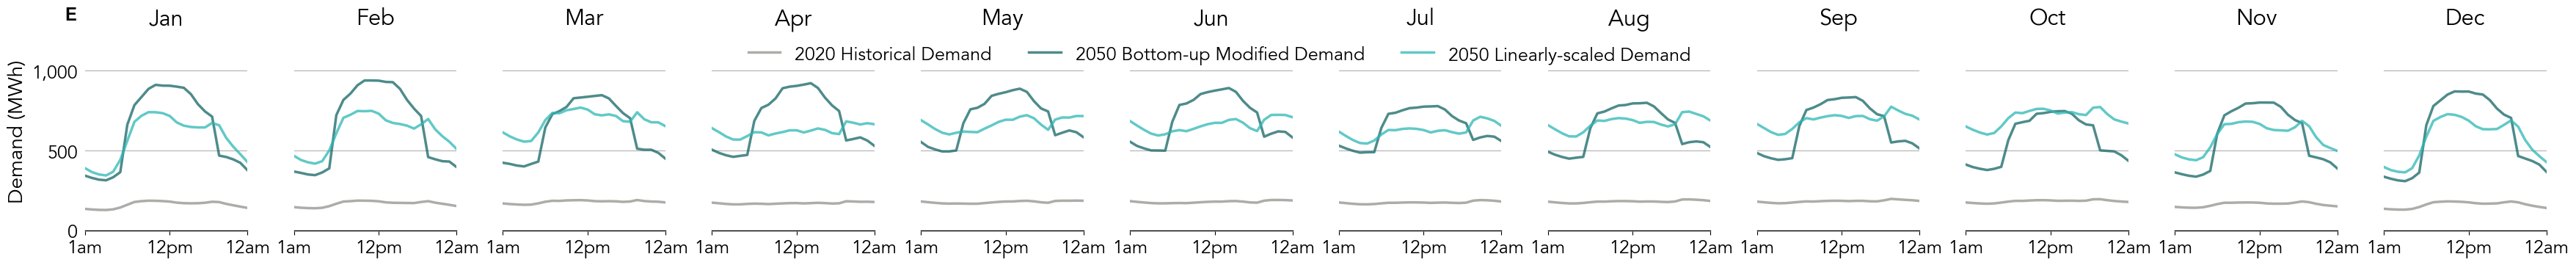

In [1004]:
method = 'avg'

scen_labels_ = [r'Bottom-up Modified Demand', 
                r'Linearly-scaled Demand']

scens_ = ['2050-demand_forecast-transmission-PIERv2_2019_mid',
          '2050-demand_forecast-transmission-ICED_2019_mid']

fys_   = [2020, 2050]

df_ = _load_system_demand_scenarios(scens_, scen_labels_, path_to_load)

fig, _ax = plt.subplot_mosaic([['A', 'B', 'C', 'D', 'E', 'F', 'G', 'H', 'I', 'J', 'K', 'L']],
                              layout      = 'constrained', 
                              figsize     = (35, 3.5), 
                              sharey      = True,
                              sharex      = True,
                              gridspec_kw = {'width_ratios': [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1]})

_ax['A'].text(0.0, 1.0, 'E', 
        transform = _ax['A'].transAxes + ScaledTranslation(-20/72, +7/72, fig.dpi_scale_trans),
        fontsize  = 'xx-large', 
        weight    = "bold",
        va        = 'bottom',
        family    = 'Arial')
    
_plot_monthly_demand_comparison(_ax['A'], df_, scen_labels_, fys_, 0, ylabel = 'Demand (MWh)', xlabel = '')
_plot_monthly_demand_comparison(_ax['B'], df_, scen_labels_, fys_, 1, ylabel = '', xlabel = '')
_plot_monthly_demand_comparison(_ax['C'], df_, scen_labels_, fys_, 2, ylabel = '', xlabel = '')
_plot_monthly_demand_comparison(_ax['D'], df_, scen_labels_, fys_, 3, ylabel = '', xlabel = '')
_plot_monthly_demand_comparison(_ax['E'], df_, scen_labels_, fys_, 4, ylabel = '', xlabel = '')
_plot_monthly_demand_comparison(_ax['F'], df_, scen_labels_, fys_, 5, ylabel = '', xlabel = '')
_plot_monthly_demand_comparison(_ax['G'], df_, scen_labels_, fys_, 6, ylabel = '', xlabel = '')
_plot_monthly_demand_comparison(_ax['H'], df_, scen_labels_, fys_, 7, ylabel = '', xlabel = '')
_plot_monthly_demand_comparison(_ax['I'], df_, scen_labels_, fys_, 8, ylabel = '', xlabel = '')
_plot_monthly_demand_comparison(_ax['J'], df_, scen_labels_, fys_, 9, ylabel = '', xlabel = '')
_plot_monthly_demand_comparison(_ax['K'], df_, scen_labels_, fys_, 10, ylabel = '', xlabel = '')
_plot_monthly_demand_comparison(_ax['L'], df_, scen_labels_, fys_, 11, ylabel = '', xlabel = '')

handles, labels = _ax['L'].get_legend_handles_labels()
fig.legend(handles, labels, loc          = (0.2875, 0.725),
                            frameon      = False,
                            handlelength = 1.75,
                            ncol         = 3,
                            prop         = {'size': 18})

plt.savefig(path_to_images + f'/overview-demand_profiles.pdf', 
            bbox_inches = 'tight', 
            dpi         = 600)

plt.savefig(path_to_images + f'/overview-demand_profiles.png', 
            bbox_inches = 'tight', 
            dpi         = 300)

plt.show()

# Electricity Generation 2020

In [453]:
def _load_system_demand_scenarios(scenario, path):

    dfs_ = []
    for file in os.listdir(path + "/" + scenario):
        if file.endswith(".csv"):
            #print(file)
            dfs_ += [pd.read_csv(path + '/' + scenario + '/' + file)]

    df_ = dfs_[0]
    for i in range(len(dfs_) - 1):
        df_ = df_.merge(dfs_[i + 1], on = ['FY', 'Month', 'Day', 'Interval', 'Year'])

    df_ = df_.drop(columns = ['Bhutan', 'India'])
    return df_


tech_labels_ = pd.read_csv(path_to_csvs + '/technology_labels.csv')

df_ = _load_system_demand_scenarios(scenario = '2050-demand_forecast-transmission-ICED_2019_mid', 
                                    path     = path_to_load)

df_p_   = df_.loc[df_['FY'] == 2020].copy()
df_p_   = df_p_[df_p_.columns[5:]].T


(34, 2)


In [493]:
gen_ = pd.read_csv(path_to_data + "india_gen_2019-20.csv")
idx_ = gen_['state'] == 'Andaman and Nicobar Islands'
gen_ = gen_.loc[~idx_].reset_index(drop = True)

gen_.loc[gen_['source'] == 'Oil & Gas', 'source']   = 'Gas'
gen_.loc[gen_['source'] == 'Bio Power', 'source']   = 'Other'
gen_.loc[gen_['source'] == 'Small Hydro', 'source'] = 'Hydro'

gen_['type'] = 'clean'

gen_.loc[gen_['source'].isin(['Coal', 'Gas', 'Diesel', 'Nuclear']), 'type'] = 'no_clean'

gen_ = gen_[['state', 'source', 'type', 'generation_gwh']]
gen_ = gen_.groupby(['state', 'source', 'type', 'generation_gwh']).agg('sum').reset_index(drop = False)
gen_['state'] = gen_['state'].apply(lambda x: x.replace(' ', '_'))
gen_['state'] = gen_['state'].apply(lambda x: x.replace('_and_', '_'))
gen_ = gen_.rename(columns = {'state': 'load_zone', 'source': 'technology'})
print(gen_)

          load_zone technology      type  generation_gwh
0    Andhra_Pradesh       Coal  no_clean        56916.07
1    Andhra_Pradesh        Gas  no_clean         3013.62
2    Andhra_Pradesh      Hydro     clean          298.19
3    Andhra_Pradesh      Hydro     clean         3013.43
4    Andhra_Pradesh      Other     clean          213.27
..              ...        ...       ...             ...
155     West_Bengal        Gas  no_clean            0.00
156     West_Bengal      Hydro     clean          115.68
157     West_Bengal      Hydro     clean         2916.38
158     West_Bengal      Other     clean         1295.07
159     West_Bengal      Solar     clean           64.29

[160 rows x 4 columns]


In [462]:
load_zones_ = pd.read_csv(path_to_input + r"/india_zones.csv")
load_zones_ = load_zones_.drop(columns = ['state', 'rps_zone'])
load_zones_ = load_zones_.drop([3, 7, 8, 36]).reset_index(drop = True)
load_zones_ = pd.merge(city_, load_zones_, on  = 'load_zone_abr', 
                                           how = 'inner')

demand_ = pd.DataFrame(np.vstack([np.sum(df_p_.to_numpy(), axis = 1), 
                                  df_p_.index.values]).T, columns = ['load_mw', 'load_zone'])

demand_ = demand_.drop([1, 26]).reset_index(drop = True)
demand_ = pd.merge(demand_, load_zones_, on  = 'load_zone', 
                                         how = 'inner')
print(demand_)

             load_mw          load_zone load_zone_abr         region  \
0   133352716.643796      Uttar_Pradesh            UP        Central   
1    10761795.722244   Himachal_Pradesh            HP       Northern   
2     3045309.363199         Puducherry            PY       Southern   
3      488250.529912             Sikkim            SK  North-Eastern   
4      339825.448852           Nagaland            NL  North-Eastern   
5    82781945.684012          Karnataka            KA       Southern   
6   172817872.030009        Maharashtra            MH        Western   
7      252003.237922            Mizoram            MZ  North-Eastern   
8    35319488.810854              Bihar            BR        Eastern   
9      559942.242342            Tripura            TR  North-Eastern   
10   48506598.892496       Chhattisgarh            CG        Central   
11   64016799.145217             Punjab            PB       Northern   
12  117410732.787581         Tamil_Nadu            TN       Sout

In [470]:
scen = 'VREmid_STmid_CONVmid_H2_RES_10PRM_CC_50RPS_90CAP_500GW_PIERmid'

project_timepoint_ = pd.read_csv(f'{path_to_scenarios}/cost/{scen}/results/project_timepoint.csv', low_memory = False)
project_period_ = pd.read_csv(f'{path_to_scenarios}/cost/{scen}/results/project_period.csv', low_memory = False)

project_timepoint_['gen_mw'] = project_timepoint_['number_of_hours_in_timepoint'] * project_timepoint_['timepoint_weight'] * project_timepoint_['power_mw']
project_timepoint_           = project_timepoint_[['period', 'load_zone', 'technology', 'gen_mw']]
project_period_              = project_period_[['period', 'load_zone', 'technology', 'capacity_mw']]

project_timepoint_ = project_timepoint_.groupby(['period', 'load_zone', 'technology']).agg('sum').reset_index(drop = False)
project_period_    = project_period_.groupby(['period', 'load_zone', 'technology']).agg('sum').reset_index(drop = False)

project_timepoint_ = project_timepoint_.loc[project_timepoint_['period'] == 2020].reset_index(drop = True)
project_period_    = project_period_.loc[project_period_['period'] == 2020].reset_index(drop = True)

project_ = pd.merge(project_period_, project_timepoint_, on  = ['period', 'technology', 'load_zone'], 
                                                         how = 'inner').drop(columns = ['period'])


          load_zone              technology  capacity_mw        gen_mw
0    Andhra_Pradesh                 Battery        0.000  0.000000e+00
1    Andhra_Pradesh                 Biomass      483.670  2.125407e+05
2    Andhra_Pradesh                    CCGT     4898.544  2.852720e+06
3    Andhra_Pradesh                      CT        0.000  0.000000e+00
4    Andhra_Pradesh               Hydro_ROR       50.000  5.337519e+04
..              ...                     ...          ...           ...
306     West_Bengal            SolarPV_tilt      110.000  1.702075e+05
307     West_Bengal  Subcritical_Coal_Large     4500.000  3.087906e+07
308     West_Bengal  Subcritical_Coal_Small     9196.948  5.907821e+07
309     West_Bengal      Supercritical_Coal     1200.000  8.508995e+06
310     West_Bengal                    Wind        0.000  0.000000e+00

[311 rows x 4 columns]


In [573]:
def _group_capacity_technologies(capacity_, tech_labels_):

    for group in tech_labels_['group'].unique():
        capacity_.loc[capacity_['technology'].isin(tech_labels_.loc[tech_labels_['group'] == group, 'technology']), 'technology'] = group
        
    capacity_ = capacity_.groupby(['technology', 
                                   'load_zone']).agg({'capacity_mw': 'sum', 
                                                      'gen_mw': 'sum'})

    return capacity_.reset_index(drop = False)

tech_labels_ = pd.read_csv(path_to_csvs + '/technology_labels.csv') 

captive_ = pd.read_csv(path_to_input + r"/generators/existing_captive_generators_2022.csv")

grouped_project_ = _group_capacity_technologies(project_, tech_labels_)
grouped_project_ = grouped_project_.loc[grouped_project_['technology'] == 'Coal'].reset_index(drop = True)
grouped_project_['cf'] = grouped_project_['gen_mw']/(grouped_project_['capacity_mw']*8760)
grouped_project_ = grouped_project_[['technology', 'load_zone', 'cf']]
# print(grouped_project_)
captive_ = captive_[['load_zone', 'gen_capacity']].drop([5]).reset_index(drop = True)

captive_ = pd.merge(grouped_project_, captive_, on  = ['load_zone'], 
                                                how = 'inner')
print(captive_)


captive_['generation_gwh'] = .77 * captive_['gen_capacity'] * captive_['cf'] * 8760 / 1000
captive_['type'] = 'no_clean'

captive_ = captive_[['load_zone', 'technology', 'type', 'generation_gwh']]
total_gen_ = pd.concat([gen_, captive_], axis = 0).reset_index(drop = True)
total_gen_ = total_gen_.groupby(['technology', 
                                 'load_zone', 
                                 'type']).agg('sum').reset_index(drop = False)
    
print(total_gen_['load_zone'].unique())
print(total_gen_['load_zone'].unique().shape)


   technology         load_zone        cf  gen_capacity
0        Coal    Andhra_Pradesh  0.422860      1928.618
1        Coal             Assam  0.000000       133.310
2        Coal             Bihar  0.519099       225.500
3        Coal        Chandigarh  0.482445        14.400
4        Coal      Chhattisgarh  0.727423      7791.048
5        Coal               Goa  0.453015        84.320
6        Coal           Gujarat  0.615376      4124.705
7        Coal           Haryana  0.229679       374.300
8        Coal  Himachal_Pradesh  0.538133        33.100
9        Coal         Jharkhand  0.705232      1405.120
10       Coal         Karnataka  0.175577      3970.921
11       Coal            Kerala  0.186133        62.300
12       Coal    Madhya_Pradesh  0.695830      2687.703
13       Coal       Maharashtra  0.285055      3867.499
14       Coal         Meghalaya  0.427423        38.800
15       Coal            Odisha  0.664235     10782.680
16       Coal        Puducherry  0.433306       

In [848]:
def _plot_dispatch_by_zone(ax, df_1_, df_2_, tech_label_,
                           units       = 1e3,
                           y_lim_min   = -10,
                           y_lim_max   = 10,
                           ylabel      = r'Electricity Generation (TWh)',
                           title       = ''):

    def __make_dispatch_legend(ax, df_, techs_):
        
        tech_idx_ = np.sort(np.unique(techs_['order']))

        for i_tech in tech_idx_:
            tech  = tech_label_.loc[tech_label_['order'] == i_tech, 'group'].unique()[0]
            color = tech_label_.loc[tech_label_['order'] == i_tech, 'group_color'].unique()[0]
            
            idx_ = df_['technology'] == tech
            
            if idx_.sum() > 0:
                if df_.loc[idx_, 'generation_gwh'].to_numpy().sum() != 0:
                    ax.bar(0., 0., 0., bottom = 0.,
                                       color  = color,
                                       label  = tech.replace('_', ' '),
                                       zorder = 2,
                                       ec     = 'None',
                                       lw     = 0.,
                                       aa     = True)

    tech_idx_ = np.sort(np.unique(tech_label_['order']))

    total_ = df_1_.groupby(['load_zone']).agg('sum').reset_index(drop = False)#.sort_values('generation_gwh', ascending = False)
    #total_ = df_1_.loc[df_1_['type']== 'clean'].groupby(['state']).agg('sum').reset_index(drop = False).sort_values('generation_gwh', ascending = False)
    #print(total_)
    total_ = total_.loc[total_['generation_gwh'] > 0.].reset_index(drop = True)
        
    #zones_ = total_['load_zone'].to_numpy()
    
    zones_ = df_2_.sort_values('load_mw', ascending = False)['load_zone'].to_numpy()
    abrs_  = df_2_.sort_values('load_mw', ascending = False)['load_zone_abr'].to_numpy()
    
    width = 0.75
    x_    = np.linspace(0, len(zones_) - 1, len(zones_))

    ticks_    = []
    x_period_ = []
    y_period_ = []
    
    i_scen          = 0
    offset_positive = 0.
    offset_negative = 0.    
    y_max           = 0
    y_min           = 0
    
    gen = 0.
    demand = 0.

    __make_dispatch_legend(ax, df_1_, tech_label_)
    
    for zone, i_zone in zip(zones_, range(len(zones_))):

        for i_tech in tech_idx_:
            tech  = tech_label_.loc[tech_label_['order'] == i_tech, 'group'].unique()[0]
            color = tech_label_.loc[tech_label_['order'] == i_tech, 'group_color'].unique()[0]
            
            idx_ = (df_1_['load_zone'] == zone) & (df_1_['technology'] == tech)

            if (idx_.sum() > 0):
                power = df_1_.loc[idx_, 'generation_gwh'].sum()

                if power != 0:
                    if power > 0:
                        offset = offset_positive
                    else:
                        offset = offset_negative
                    gen += power/units
                    ax.bar(x_[i_zone], power/units, width, bottom = offset/units,
                                                           color  = color,
                                                           zorder = 2,
                                                           ec     = 'None',
                                                           lw     = 0.,
                                                           aa     = True)

                    if power >= 0:
                        offset_positive += power
                    else:
                        offset_negative += power

        if offset_negative/units < y_min: 
            y_min = offset_negative/units
        if offset_positive/units > y_max: 
            y_max = offset_positive/units

        #idx_ =#.replace(' and ', ' ').replace(' ', '_')
        power = df_2_.loc[df_2_['load_zone'] == zone, 'load_mw'].to_numpy()[0]/1e6

        if i_zone == 0:
            ax.plot(x_[i_zone], power, marker          = 'o', 
                                       c               = 'white', 
                                       label           = 'Demand (TWh)',
                                       zorder          = 6,
                                       markersize      = 10,
                                       markeredgewidth = 2.5,
                                       markeredgecolor = 'k', clip_on = False)
        else:
            ax.plot(x_[i_zone], power, marker          = 'o', 
                                       c               = 'white', 
                                       zorder          = 6, 
                                       markersize      = 10,
                                       markeredgewidth = 2.5,
                                       markeredgecolor = 'k', clip_on = False)
            
        ticks_.append(x_[i_zone])
        x_period_.append(x_[i_zone])
        y_period_.append(offset_positive)

        offset_positive = 0.
        offset_negative = 0.

    x_ = x_ + .9/len(zones_)  
    
    labels_ = ['{} ({})'.format(zone.replace("_", " "), abr) for zone, abr in zip(zones_, abrs_)]
    ax.set_xticks(ticks_, labels_, rotation = 90)
    ax.xaxis.set_tick_params(labelsize = 18, left = False)
    ax.set_ylabel(ylabel, fontsize = 20)
    ax.yaxis.set_tick_params(labelsize = 18, left = False)
    #ax.yaxis.set_major_formatter(mpl.ticker.StrMethodFormatter('{x:,.0f}'))

    # if legend:
    #     ax.legend(bbox_to_anchor = (1., 0.95),
    #               frameon        = False,
    #               prop           = {'size': 20})

    ax.set_ylim(y_lim_min, y_lim_max)

    ax.set_xlim(-1, len(zones_))

    #ax.set_title(title, fontsize = 18)

    ax.spines[['right', 'top', 'left', 'bottom']].set_visible(False)
    ax.grid(axis = 'y')

# fig = plt.figure(figsize = (35, 7))
# _ax = plt.subplot(111)

# _plot_dispatch_by_zone(_ax, gen_, demand_, tech_labels_, 
#                        y_lim_min   = -1,
#                        y_lim_max   = 180,
#                        title       = f' ',
#                        ylabel      = 'Electricity Generation (TWh)')

# plt.savefig(path_to_images + f'/gen_2019-2020.png', 
#             bbox_inches = 'tight', 
#             dpi         = 600)

# plt.show()


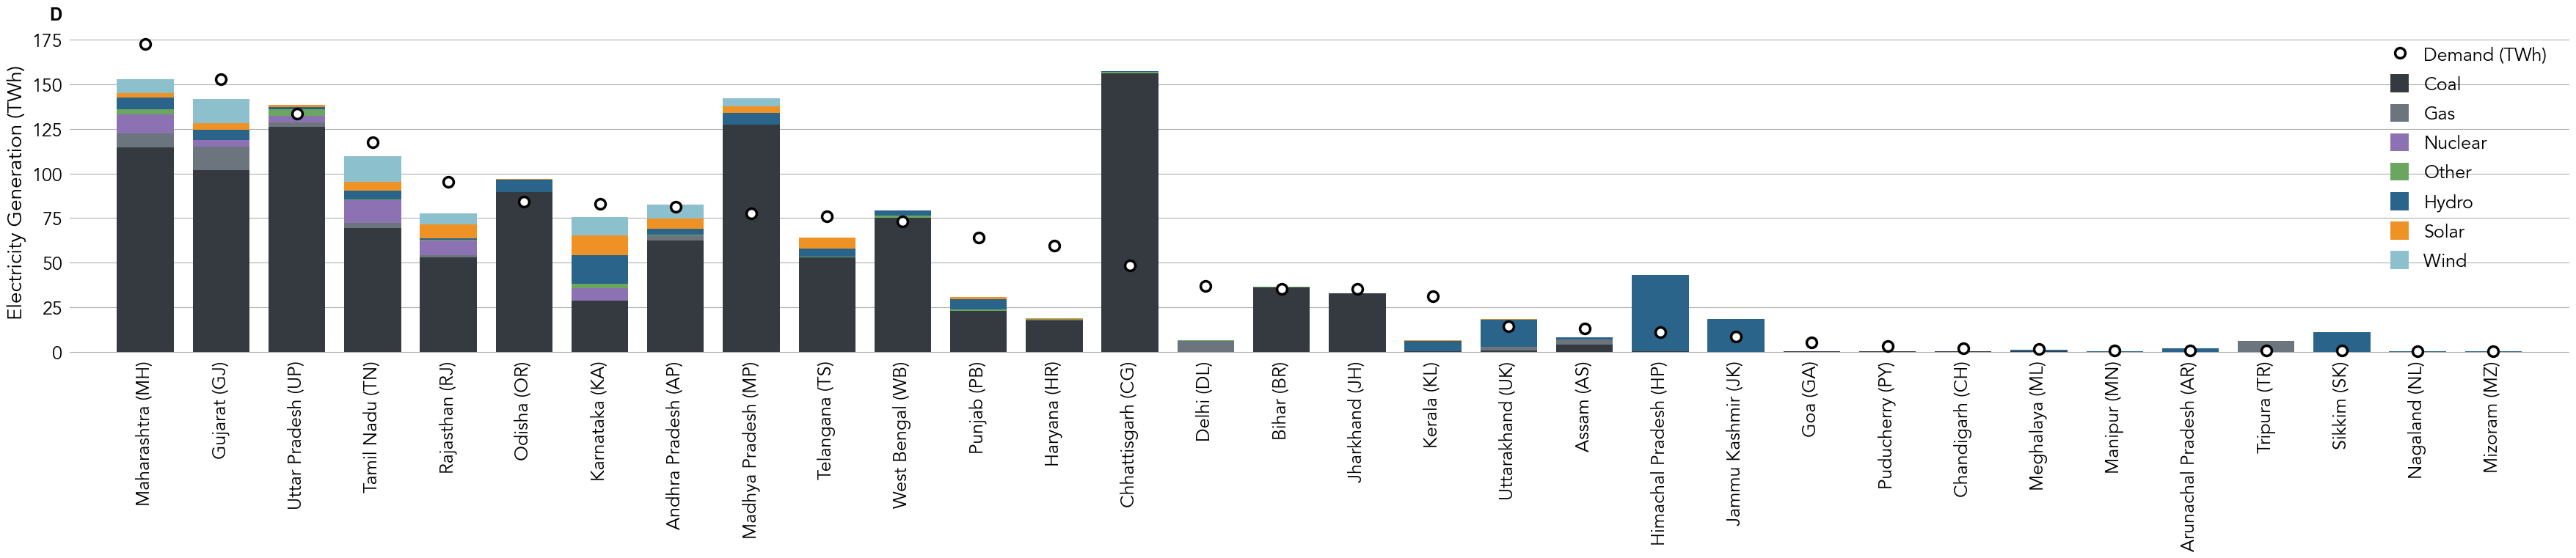

In [1037]:
fig, _ax = plt.subplot_mosaic([['D']],
                              layout      = 'constrained', 
                              sharex      = True,
                              figsize     = (35, 7.5), 
                              gridspec_kw = {'width_ratios': [1]})


_ax['D'].text(0.0, 1.0, 'D', 
        transform = _ax['D'].transAxes + ScaledTranslation(-20/72, +7/72, fig.dpi_scale_trans),
        fontsize  = 'xx-large', 
        weight    = "bold",
        va        = 'bottom',
        family    = 'Arial')

_plot_dispatch_by_zone(_ax['D'], total_gen_, demand_, tech_labels_, 
                       y_lim_min   = -1,
                       y_lim_max   = 180,
                       title       = f' ',
                       ylabel      = 'Electricity Generation (TWh)')

handles, labels = _ax['D'].get_legend_handles_labels()
fig.legend(handles, labels, loc          = (0.925, 0.5),
                            frameon      = False,
                            ncol         = 1,
                            prop         = {'size': 18})

plt.savefig(path_to_images + f'/overview-state_generation.png', 
            bbox_inches = 'tight', 
            dpi         = 300)

plt.savefig(path_to_images + f'/overview-state_generation.pdf', 
            bbox_inches = 'tight', 
            dpi         = 600)

plt.show()

# Technology Cost Projections

In [896]:
# New projects costs and operational characteristics
new_projects_excel            = path_to_input + "new_projects_v37.xlsx"
new_battery_costs_all         = pd.read_excel(new_projects_excel, sheet_name = "adapted_new_battery_costs_2050")
new_hydrogen_cavern_costs_all = pd.read_excel(new_projects_excel, sheet_name = "new_hydrogen_cavern_costs_2050")
new_hydrogen_tank_costs_all   = pd.read_excel(new_projects_excel, sheet_name = "new_hydrogen_tank_costs_2050")
new_solar_costs_all           = pd.read_excel(new_projects_excel, sheet_name = "adapted_new_solar_costs_2050")
new_wind_costs_all            = pd.read_excel(new_projects_excel, sheet_name = "adapted_new_wind_costs_2050")
new_conventional_costs_all    = pd.read_excel(new_projects_excel, sheet_name = "new_conventional_costs_2050")
new_nuclear_costs_all         = pd.read_excel(new_projects_excel, sheet_name = "new_nuclear_costs_2050")
new_hydro_costs_all           = pd.read_excel(new_projects_excel, sheet_name = "new_hydro_pumped_costs_2050")

# Exchange Rate
USD_to_INR = 72

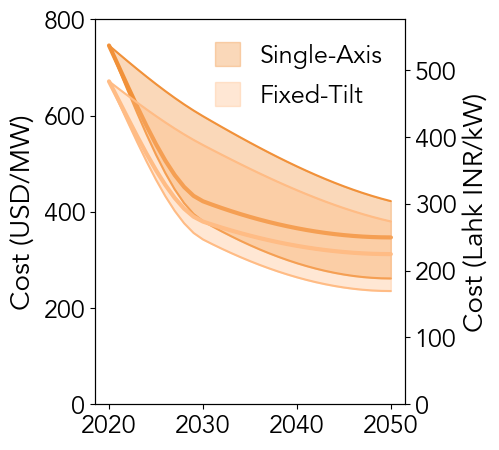

In [897]:
def _plot_solar_cost(ax, df_, 
                     ylabel  = r'Technology Cost (USD/MW)',
                     yplabel = r'Technology Cost (Lahk INR/kW)',
                     xlabel  = True):

    idx_single_low_  = (df_['scenario'] == 'PVlow') & (df_['technology'] == 'SolarPV_single')
    idx_single_mid_  = (df_['scenario'] == 'PVmid') & (df_['technology'] == 'SolarPV_single')
    idx_single_high_ = (df_['scenario'] == 'PVhigh') & (df_['technology'] == 'SolarPV_single')

    idx_tilt_low_  = (df_['scenario'] == 'PVlow') & (df_['technology'] == 'SolarPV_tilt')
    idx_tilt_mid_  = (df_['scenario'] == 'PVmid') & (df_['technology'] == 'SolarPV_tilt')
    idx_tilt_high_ = (df_['scenario'] == 'PVhigh') & (df_['technology'] == 'SolarPV_tilt')

    idx_roof_low_  = (df_['scenario'] == 'PVlow') & (df_['technology'] == 'SolarPV_roof')
    idx_roof_mid_  = (df_['scenario'] == 'PVmid') & (df_['technology'] == 'SolarPV_roof')
    idx_roof_high_ = (df_['scenario'] == 'PVhigh') & (df_['technology'] == 'SolarPV_roof')

    ax.plot(df_.loc[idx_single_low_, 'vintage'], df_.loc[idx_single_low_, 'capital_real_cost_per_kw'],
            color = '#f19139', lw = 1.5, zorder = 1, solid_capstyle='round')
    ax.plot(df_.loc[idx_single_mid_, 'vintage'], df_.loc[idx_single_mid_, 'capital_real_cost_per_kw'],
            color = '#f19139', lw = 3, zorder = 1, solid_capstyle='round')
    ax.plot(df_.loc[idx_single_high_, 'vintage'], df_.loc[idx_single_high_, 'capital_real_cost_per_kw'],
            color = '#f19139', lw = 1.5, zorder = 1, solid_capstyle='round')

    ax.fill_between(df_.loc[idx_single_mid_, 'vintage'], 
                    df_.loc[idx_single_low_, 'capital_real_cost_per_kw'],
                    df_.loc[idx_single_high_, 'capital_real_cost_per_kw'], 
                    color = '#f19139', alpha = .35, label = 'Single-Axis', zorder = 1)
    
#     ax.plot(df_.loc[idx_roof_low_, 'vintage'], df_.loc[idx_roof_low_, 'capital_real_cost_per_kw'],
#             color = '#ffbc85', lw = 1.5, zorder = 2, solid_capstyle='round')
#     ax.plot(df_.loc[idx_roof_mid_, 'vintage'], df_.loc[idx_roof_mid_, 'capital_real_cost_per_kw'],
#             color = '#ffbc85', lw = 3, zorder = 2, solid_capstyle='round')
#     ax.plot(df_.loc[idx_roof_high_, 'vintage'], df_.loc[idx_roof_high_, 'capital_real_cost_per_kw'],
#             color = '#ffbc85', lw = 1.5, zorder = 2, solid_capstyle='round')
    
#     ax.fill_between(df_.loc[idx_roof_mid_, 'vintage'], 
#                     df_.loc[idx_roof_low_, 'capital_real_cost_per_kw'],
#                     df_.loc[idx_roof_high_, 'capital_real_cost_per_kw'], 
#                     color = '#ffbc85', alpha = .35, label = 'Rooftop', zorder = 2)
    
    ax.plot(df_.loc[idx_tilt_low_, 'vintage'], df_.loc[idx_tilt_low_, 'capital_real_cost_per_kw'],
            color = '#ffbc85', lw = 1.5, zorder = 3, solid_capstyle='round')
    ax.plot(df_.loc[idx_tilt_mid_, 'vintage'], df_.loc[idx_tilt_mid_, 'capital_real_cost_per_kw'],
            color = '#ffbc85', lw = 3, zorder = 3, solid_capstyle='round')
    ax.plot(df_.loc[idx_tilt_high_, 'vintage'], df_.loc[idx_tilt_high_, 'capital_real_cost_per_kw'],
            color = '#ffbc85', lw = 1.5, zorder = 3, solid_capstyle='round')

    ax.fill_between(df_.loc[idx_tilt_mid_, 'vintage'], 
                    df_.loc[idx_tilt_low_, 'capital_real_cost_per_kw'],
                    df_.loc[idx_tilt_high_, 'capital_real_cost_per_kw'], 
                    color = '#ffbc85', alpha = .35, label = 'Fixed-Tilt', zorder = 3)
    
    ax.legend(loc     = 'upper right',
              frameon = False,
              prop    = {'size': 18})
    
    axp = ax.twinx()

    ax.xaxis.set_tick_params(labelsize = 18)
    ax.yaxis.set_tick_params(labelsize = 18)
    axp.yaxis.set_tick_params(labelsize = 18)
    
    ax.set_ylabel(ylabel, fontsize = 20)
    axp.set_ylabel(yplabel, fontsize = 20)
    
    ax.yaxis.set_major_formatter(mpl.ticker.StrMethodFormatter('{x:,.0f}'))
    axp.yaxis.set_major_formatter(mpl.ticker.StrMethodFormatter('{x:,.0f}'))
    
    ax.set_ylim(0, 800)
    axp.set_ylim(0, 800*USD_to_INR/1e2)

    plt.setp(ax.get_xticklabels(), visible = xlabel)

fig, ax = plt.subplots(1, 1, figsize = (4, 5))

_plot_solar_cost(ax, new_solar_costs_all)

# plt.savefig(path_to_images + '/existing_capacity.png', 
#             bbox_inches = 'tight', 
#             dpi         = 300)

plt.show()

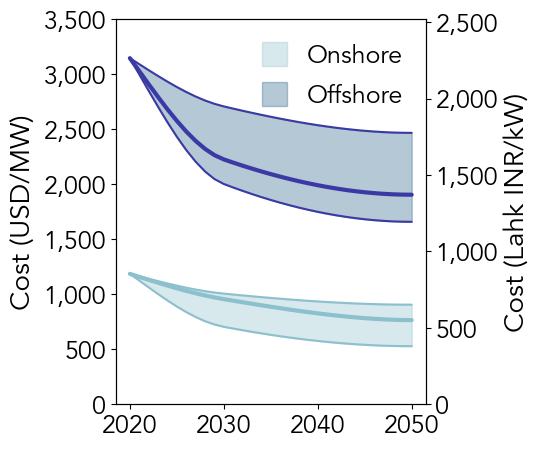

In [898]:
def _plot_wind_cost(ax, df_, 
                    ylabel  = r'Technology Cost (USD/MW)',
                    yplabel = r'Technology Cost (Lahk INR/kW)', 
                    xlabel  = True):

    idx_on_low_  = (df_['scenario'] == 'WDlow') & (df_['technology'] == 'Wind')
    idx_on_mid_  = (df_['scenario'] == 'WDmid') & (df_['technology'] == 'Wind')
    idx_on_high_ = (df_['scenario'] == 'WDhigh') & (df_['technology'] == 'Wind')

    idx_off_low_  = (df_['scenario'] == 'WDlow') & (df_['technology'] == 'Offshore')
    idx_off_mid_  = (df_['scenario'] == 'WDmid') & (df_['technology'] == 'Offshore')
    idx_off_high_ = (df_['scenario'] == 'WDhigh') & (df_['technology'] == 'Offshore')

    ax.plot(df_.loc[idx_on_low_, 'vintage'], df_.loc[idx_on_low_, 'capital_real_cost_per_kw'],
            color = '#8dc0cd', lw = 1.5, solid_capstyle='round')
    ax.plot(df_.loc[idx_on_mid_, 'vintage'], df_.loc[idx_on_mid_, 'capital_real_cost_per_kw'],
            color = '#8dc0cd', lw = 3, solid_capstyle='round')
    ax.plot(df_.loc[idx_on_high_, 'vintage'], df_.loc[idx_on_high_, 'capital_real_cost_per_kw'],
            color = '#8dc0cd', lw = 1.5, solid_capstyle='round')
    
    ax.fill_between(df_.loc[idx_on_mid_, 'vintage'], 
                    df_.loc[idx_on_low_, 'capital_real_cost_per_kw'],
                    df_.loc[idx_on_high_, 'capital_real_cost_per_kw'], 
                    color = '#8dc0cd', alpha = 0.35, label = 'Onshore')

    ax.plot(df_.loc[idx_off_low_, 'vintage'], df_.loc[idx_off_low_, 'capital_real_cost_per_kw'],
            color = '#3b3aa5', lw = 1.5, solid_capstyle='round')
    ax.plot(df_.loc[idx_off_mid_, 'vintage'], df_.loc[idx_off_mid_, 'capital_real_cost_per_kw'],
            color = '#3b3aa5', lw = 3, solid_capstyle='round')
    ax.plot(df_.loc[idx_off_high_, 'vintage'], df_.loc[idx_off_high_, 'capital_real_cost_per_kw'],
            color = '#3b3aa5', lw = 1.5, solid_capstyle='round')
    
    ax.fill_between(df_.loc[idx_off_mid_, 'vintage'], 
                    df_.loc[idx_off_low_, 'capital_real_cost_per_kw'],
                    df_.loc[idx_off_high_, 'capital_real_cost_per_kw'], 
                    color = '#2a648a', alpha = 0.35, label = 'Offshore')
    
    ax.legend(loc     = 'upper right',
              frameon = False,
              prop    = {'size': 18})

    axp = ax.twinx()

    ax.xaxis.set_tick_params(labelsize = 18)
    ax.yaxis.set_tick_params(labelsize = 18)
    axp.yaxis.set_tick_params(labelsize = 18)
    
    ax.set_ylabel(ylabel, fontsize = 20)
    axp.set_ylabel(yplabel, fontsize = 20)
    
    ax.yaxis.set_major_formatter(mpl.ticker.StrMethodFormatter('{x:,.0f}'))
    axp.yaxis.set_major_formatter(mpl.ticker.StrMethodFormatter('{x:,.0f}'))
    
    ax.set_ylim(0, 3500)
    axp.set_ylim(0, 3500*USD_to_INR/1e2)
    
    plt.setp(ax.get_xticklabels(), visible = xlabel)


fig, ax = plt.subplots(1, 1, figsize = (4, 5))

_plot_wind_cost(ax, new_wind_costs_all)

# plt.savefig(path_to_images + '/existing_capacity.png', 
#             bbox_inches = 'tight', 
#             dpi         = 300)

plt.show()

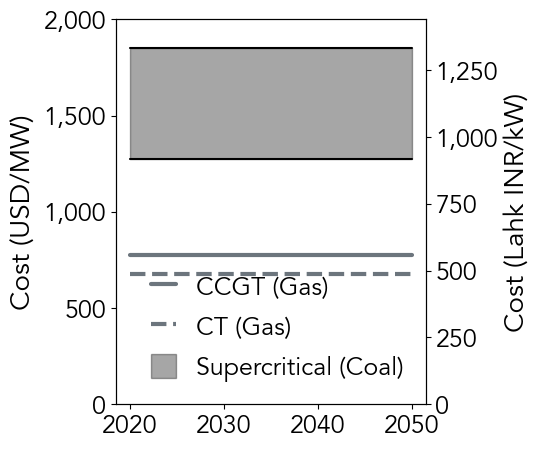

In [899]:
def _plot_convectional_cost(ax, df_,
                            ylabel  = r'Technology Cost (USD/MW)',
                            yplabel = r'Technology Cost (Lahk INR/kW)',
                            xlabel  = True):
    
    idx_coal_low_  = (df_['scenario'] == 'CONVmid') & (df_['technology'] == 'Supercritical_Coal')
    idx_coal_high_ = (df_['scenario'] == 'CONVhigh') & (df_['technology'] == 'Supercritical_Coal')

    idx_ccgt_  = (df_['scenario'] == 'CONVmid') & (df_['technology'] == 'CCGT')
    idx_ct_ = (df_['scenario'] == 'CONVmid') & (df_['technology'] == 'CT')

    ax.plot(df_.loc[idx_coal_low_, 'vintage'], df_.loc[idx_coal_low_, 'capital_real_cost_per_kw'], 
            color = 'k', lw = 1.5, solid_capstyle='round')
    ax.plot(df_.loc[idx_coal_high_, 'vintage'], df_.loc[idx_coal_high_, 'capital_real_cost_per_kw'], 
            color = 'k', lw = 1.5, solid_capstyle='round')

    ax.plot(df_.loc[idx_ccgt_, 'vintage'], df_.loc[idx_ccgt_, 'capital_real_cost_per_kw'], 
            color = '#6c757d', lw = 3, solid_capstyle='round', label = 'CCGT (Gas)')
    ax.plot(df_.loc[idx_ct_, 'vintage'], df_.loc[idx_ct_, 'capital_real_cost_per_kw'], 
            color = '#6c757d', lw = 3, solid_capstyle='round', ls = '--', label = 'CT (Gas)')
    
    ax.fill_between(df_.loc[idx_coal_low_, 'vintage'], 
                    df_.loc[idx_coal_low_, 'capital_real_cost_per_kw'],
                    df_.loc[idx_coal_high_, 'capital_real_cost_per_kw'], 
                    color = 'k', alpha = 0.35, label = 'Supercritical (Coal)')
    
    ax.legend(loc     = 'lower right',
              frameon = False,
              ncol    = 1,
              prop    = {'size': 18})
    
    axp = ax.twinx()

    ax.xaxis.set_tick_params(labelsize = 18)
    ax.yaxis.set_tick_params(labelsize = 18)
    axp.yaxis.set_tick_params(labelsize = 18)
    
    ax.set_ylabel(ylabel, fontsize = 20)
    axp.set_ylabel(yplabel, fontsize = 20)
    
    ax.yaxis.set_major_formatter(mpl.ticker.StrMethodFormatter('{x:,.0f}'))
    axp.yaxis.set_major_formatter(mpl.ticker.StrMethodFormatter('{x:,.0f}'))

    ax.set_ylim(0, 2000)
    axp.set_ylim(0, 2000*USD_to_INR/1e2)
    
    plt.setp(ax.get_xticklabels(), visible = xlabel)

    
fig, ax = plt.subplots(1, 1, figsize = (4, 5))

_plot_convectional_cost(ax, new_conventional_costs_all)

# plt.savefig(path_to_images + '/existing_capacity.png', 
#             bbox_inches = 'tight', 
#             dpi         = 300)

plt.show()

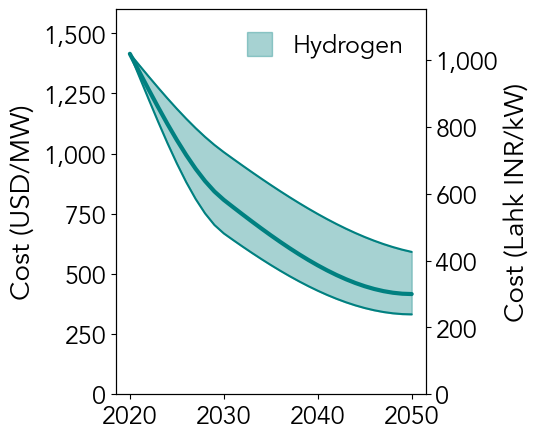

In [900]:
def _plot_hydrogen_power_cost(ax, df_,
                              ylabel  = r'Technology Cost (USD/MW)',
                              yplabel = r'Technology Cost (Lahk INR/kW)',
                              xlabel  = True):
    
    idx_low_  = df_['scenario'] == 'STlow'
    idx_mid_  = df_['scenario'] == 'STmid'
    idx_high_ = df_['scenario'] == 'SThigh'

    ax.plot(df_.loc[idx_low_, 'vintage'], df_.loc[idx_low_, 'capital_real_cost_per_kw'], 
            color = 'teal', lw = 1.5, solid_capstyle='round')
    ax.plot(df_.loc[idx_mid_, 'vintage'], df_.loc[idx_mid_, 'capital_real_cost_per_kw'], 
            color = 'teal', lw = 3, solid_capstyle='round')
    ax.plot(df_.loc[idx_high_, 'vintage'], df_.loc[idx_high_, 'capital_real_cost_per_kw'], 
            color = 'teal', lw = 1.5, solid_capstyle='round')
    
    ax.fill_between(df_.loc[idx_mid_, 'vintage'], 
                    df_.loc[idx_low_, 'capital_real_cost_per_kw'],
                    df_.loc[idx_high_, 'capital_real_cost_per_kw'], 
                    color = 'teal', alpha = 0.35, label = 'Hydrogen')
    
    ax.xaxis.set_tick_params(labelsize = 14)
    ax.yaxis.set_tick_params(labelsize = 14)
    ax.set_ylabel(ylabel, fontsize = 16)
    ax.yaxis.set_major_formatter(mpl.ticker.StrMethodFormatter('{x:,.0f}'))

    ax.legend(loc     = 'upper right',
              frameon = False,
              prop    = {'size': 18})
    
    axp = ax.twinx()

    ax.xaxis.set_tick_params(labelsize = 18)
    ax.yaxis.set_tick_params(labelsize = 18)
    axp.yaxis.set_tick_params(labelsize = 18)
    
    ax.set_ylabel(ylabel, fontsize = 20)
    axp.set_ylabel(yplabel, fontsize = 20)
    
    ax.yaxis.set_major_formatter(mpl.ticker.StrMethodFormatter('{x:,.0f}'))
    axp.yaxis.set_major_formatter(mpl.ticker.StrMethodFormatter('{x:,.0f}'))
    
    ax.set_ylim(0, 1600)
    axp.set_ylim(0, 1600*USD_to_INR/1e2)
    
    plt.setp(ax.get_xticklabels(), visible = xlabel)

fig, ax = plt.subplots(1, 1, figsize = (4, 5))

_plot_hydrogen_power_cost(ax, new_hydrogen_cavern_costs_all)

# plt.savefig(path_to_images + '/existing_capacity.png', 
#             bbox_inches = 'tight', 
#             dpi         = 300)

plt.show()

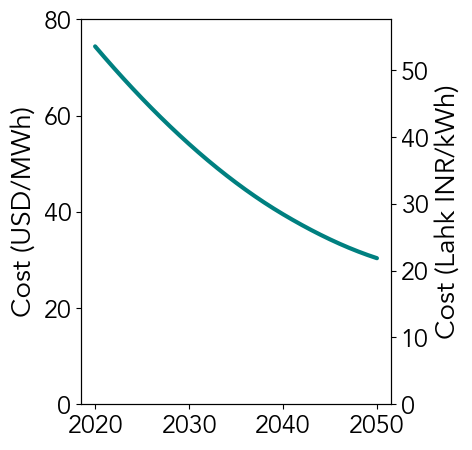

In [901]:
def _plot_hydrogen_energy_cost(ax, df_,
                               ylabel  = r'Technology Cost (USD/MWh)',
                               yplabel = r'Technology Cost (Lahk INR/kWh)',
                               xlabel  = True):
    
#     idx_low_  = df_['scenario'] == 'STlow'
#     idx_mid_  = df_['scenario'] == 'STmid'
#     idx_high_ = df_['scenario'] == 'SThigh'

#     ax.plot(df_.loc[idx_low_, 'vintage'], df_.loc[idx_low_, 'capital_real_cost_per_kwh'], 
#             color = 'teal', lw = 1.5, solid_capstyle='round')
#     ax.plot(df_.loc[idx_mid_, 'vintage'], df_.loc[idx_mid_, 'capital_real_cost_per_kwh'], 
#             color = 'teal', lw = 3, solid_capstyle='round')
#     ax.plot(df_.loc[idx_high_, 'vintage'], df_.loc[idx_high_, 'capital_real_cost_per_kwh'], 
#             color = 'teal', lw = 1.5, solid_capstyle='round')
    
#     ax.fill_between(df_.loc[idx_mid_, 'vintage'], 
#                     df_.loc[idx_low_, 'capital_real_cost_per_kwh'],
#                     df_.loc[idx_high_, 'capital_real_cost_per_kwh'], 
#                     color = 'teal', alpha = 0.35, label = 'Tank')
    
    idx_low_  = df_['scenario'] == 'STlow'
    idx_mid_  = df_['scenario'] == 'STmid'
    idx_high_ = df_['scenario'] == 'SThigh'
    
    # ax.plot(df_.loc[idx_low_, 'vintage'], df_.loc[idx_low_, 'capital_real_cost_per_kwh'], 
    #         color = 'teal', lw = 1.5)
    ax.plot(df_.loc[idx_mid_, 'vintage'], df_.loc[idx_mid_, 'capital_real_cost_per_kwh'], 
            color = 'teal',  lw = 3, label = 'Cavern', solid_capstyle='round')
    # ax.plot(df_.loc[idx_high_, 'vintage'], df_.loc[idx_high_, 'capital_real_cost_per_kwh'], 
    #         color = 'teal', lw = 1.5)
    
    # ax.fill_between(df_.loc[idx_mid_, 'vintage'], 
    #                 df_.loc[idx_low_, 'capital_real_cost_per_kwh'],
    #                 df_.loc[idx_high_, 'capital_real_cost_per_kwh'], 
    #                 color = 'teal', alpha = 0.35, label = 'Hydrogen')
    
    ax.xaxis.set_tick_params(labelsize = 14)
    ax.yaxis.set_tick_params(labelsize = 14)
    ax.set_ylabel(ylabel, fontsize = 16)
    ax.yaxis.set_major_formatter(mpl.ticker.StrMethodFormatter('{x:,.0f}'))

#     ax.legend(loc     = 'upper right',
#               frameon = False,
#               prop    = {'size': 14})
    
    axp = ax.twinx()

    ax.xaxis.set_tick_params(labelsize = 18)
    ax.yaxis.set_tick_params(labelsize = 18)
    axp.yaxis.set_tick_params(labelsize = 18)
    
    ax.set_ylabel(ylabel, fontsize = 20)
    axp.set_ylabel(yplabel, fontsize = 20)
    
    ax.yaxis.set_major_formatter(mpl.ticker.StrMethodFormatter('{x:,.0f}'))
    axp.yaxis.set_major_formatter(mpl.ticker.StrMethodFormatter('{x:,.0f}'))
    
    ax.set_ylim(0, 80)
    axp.set_ylim(0, 80*USD_to_INR/1e2)
    
    plt.setp(ax.get_xticklabels(), visible = xlabel)

fig, ax = plt.subplots(1, 1, figsize = (4, 5))

_plot_hydrogen_energy_cost(ax, new_hydrogen_tank_costs_all)

# plt.savefig(path_to_images + '/existing_capacity.png', 
#             bbox_inches = 'tight', 
#             dpi         = 300)

plt.show()

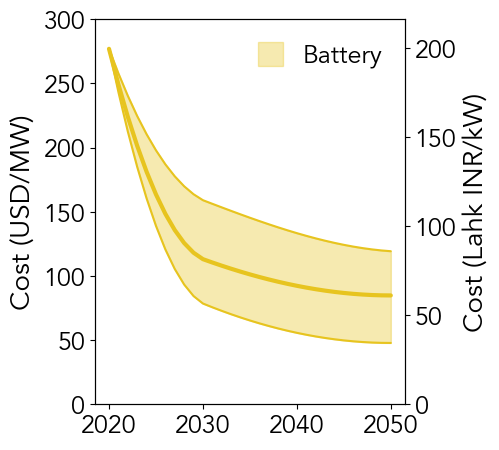

In [902]:
def _plot_battery_power_cost(ax, df_, 
                             ylabel  = r'Technology Cost (USD/MW)', 
                             yplabel = r'Technology Cost (Lahk INR/kW)',
                             xlabel  = True):
    
    idx_low_  = df_['scenario'] == 'STlow'
    idx_mid_  = df_['scenario'] == 'STmid'
    idx_high_ = df_['scenario'] == 'SThigh'

    ax.plot(df_.loc[idx_low_, 'vintage'], df_.loc[idx_low_, 'capital_real_cost_per_kw'], 
            color = '#e7c41f', lw = 1.5, solid_capstyle='round')
    ax.plot(df_.loc[idx_mid_, 'vintage'], df_.loc[idx_mid_, 'capital_real_cost_per_kw'],
            color = '#e7c41f', lw = 3, solid_capstyle='round')
    ax.plot(df_.loc[idx_high_, 'vintage'], df_.loc[idx_high_, 'capital_real_cost_per_kw'],
            color = '#e7c41f', lw = 1.5, solid_capstyle='round')
    
    ax.fill_between(df_.loc[idx_mid_, 'vintage'], 
                    df_.loc[idx_low_, 'capital_real_cost_per_kw'],
                    df_.loc[idx_high_, 'capital_real_cost_per_kw'], 
                    color = '#e7c41f', alpha = 0.35, label = 'Battery')
    
    ax.legend(loc     = 'upper right',
              frameon = False,
              prop    = {'size': 18})
    
    axp = ax.twinx()

    ax.xaxis.set_tick_params(labelsize = 18)
    ax.yaxis.set_tick_params(labelsize = 18)
    axp.yaxis.set_tick_params(labelsize = 18)
    
    ax.set_ylabel(ylabel, fontsize = 20)
    axp.set_ylabel(yplabel, fontsize = 20)
    
    ax.yaxis.set_major_formatter(mpl.ticker.StrMethodFormatter('{x:,.0f}'))
    axp.yaxis.set_major_formatter(mpl.ticker.StrMethodFormatter('{x:,.0f}'))
    
    ax.set_ylim(0, 300)
    axp.set_ylim(0, 300*USD_to_INR/1e2)
    
    plt.setp(ax.get_xticklabels(), visible = xlabel)

fig, ax = plt.subplots(1, 1, figsize = (4, 5))

_plot_battery_power_cost(ax, new_battery_costs_all)

# plt.savefig(path_to_images + '/existing_capacity.png', 
#             bbox_inches = 'tight', 
#             dpi         = 300)

plt.show()

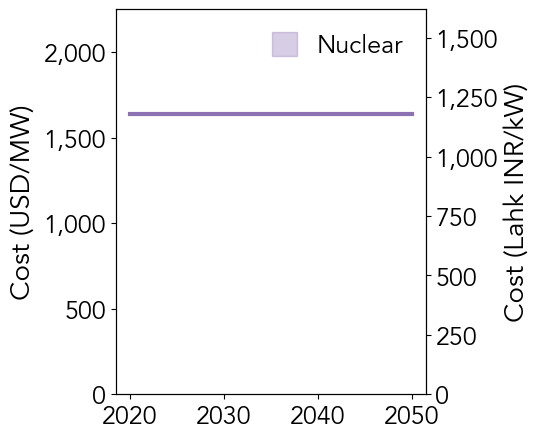

In [903]:
def _plot_nuclear_cost(ax, df_,
                       ylabel  = r'Technology Cost (USD/MW)', 
                       yplabel = r'Technology Cost (Lahk INR/kW)',
                       xlabel  = True):
    
    idx_nuclear_ = (df_['scenario'] == 'NUCLmid') & (df_['technology'] == 'Nuclear')

    ax.plot(df_.loc[idx_nuclear_, 'vintage'], df_.loc[idx_nuclear_, 'capital_real_cost_per_kw'], 
            color = '#8d72b3', lw = 3)
    
    ax.fill_between(df_.loc[idx_nuclear_, 'vintage'], 
                    df_.loc[idx_nuclear_, 'capital_real_cost_per_kw'],
                    df_.loc[idx_nuclear_, 'capital_real_cost_per_kw'], 
                    color = '#8d72b3', alpha = 0.35, label = 'Nuclear')
    
    ax.legend(loc     = 'upper right',
              frameon = False,
              prop    = {'size': 18})
    
    axp = ax.twinx()

    ax.xaxis.set_tick_params(labelsize = 18)
    ax.yaxis.set_tick_params(labelsize = 18)
    axp.yaxis.set_tick_params(labelsize = 18)
    
    ax.set_ylabel(ylabel, fontsize = 20)
    axp.set_ylabel(yplabel, fontsize = 20)
    
    ax.yaxis.set_major_formatter(mpl.ticker.StrMethodFormatter('{x:,.0f}'))
    axp.yaxis.set_major_formatter(mpl.ticker.StrMethodFormatter('{x:,.0f}'))
    
    ax.set_ylim(0, 2250)
    axp.set_ylim(0, 2250*USD_to_INR/1e2)
    
    plt.setp(ax.get_xticklabels(), visible = xlabel)


fig, ax = plt.subplots(1, 1, figsize = (4, 5))

_plot_nuclear_cost(ax, new_nuclear_costs_all)

# plt.savefig(path_to_images + '/existing_capacity.png', 
#             bbox_inches = 'tight', 
#             dpi         = 300)

plt.show()

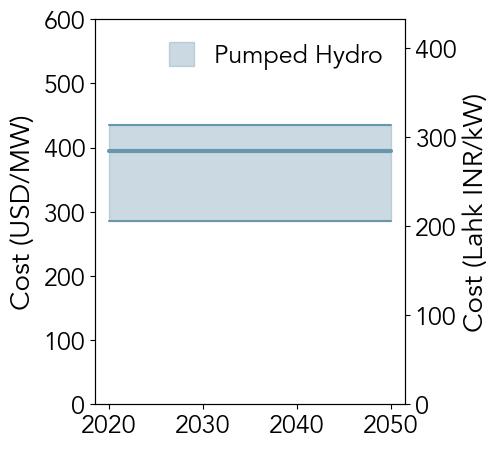

In [904]:
def _plot_phs_power_cost(ax, df_,
                         ylabel  = r'Technology Cost (USD/MW)', 
                         yplabel = r'Technology Cost (Lahk INR/kW)', 
                         xlabel = True):
    
    idx_low_  = df_['scenario'] == 'STlow'
    idx_mid_  = df_['scenario'] == 'STmid'
    idx_high_ = df_['scenario'] == 'SThigh'

    ax.plot(df_.loc[idx_low_, 'vintage'], df_.loc[idx_low_, 'capital_real_cost_per_kw'], 
            color = '#6a96ac', lw = 1.5, solid_capstyle='round')
    ax.plot(df_.loc[idx_mid_, 'vintage'], df_.loc[idx_mid_, 'capital_real_cost_per_kw'],
            color = '#6a96ac', lw = 3, solid_capstyle='round')
    ax.plot(df_.loc[idx_high_, 'vintage'], df_.loc[idx_high_, 'capital_real_cost_per_kw'],
            color = '#6a96ac', lw = 1.5, solid_capstyle='round')
    
    ax.fill_between(df_.loc[idx_mid_, 'vintage'], 
                    df_.loc[idx_low_, 'capital_real_cost_per_kw'],
                    df_.loc[idx_high_, 'capital_real_cost_per_kw'], 
                    color = '#6a96ac', alpha = 0.35, label = 'Pumped Hydro')
    
#     idx_nuclear_ = (df_1_['scenario'] == 'NUCLmid') & (df_1_['technology'] == 'Nuclear')

#     ax.plot(df_1_.loc[idx_nuclear_, 'vintage'], df_1_.loc[idx_nuclear_, 'capital_real_cost_per_kw'], 
#             color = '#8d72b3', lw = 3, label = 'Nuclear')
    
    ax.legend(loc     = 'upper right',
              frameon = False,
              prop    = {'size': 18})
    
    axp = ax.twinx()

    ax.xaxis.set_tick_params(labelsize = 18)
    ax.yaxis.set_tick_params(labelsize = 18)
    axp.yaxis.set_tick_params(labelsize = 18)
    
    ax.set_ylabel(ylabel, fontsize = 20)
    axp.set_ylabel(yplabel, fontsize = 20)
    
    axp.yaxis.set_major_formatter(mpl.ticker.StrMethodFormatter('{x:,.0f}'))

    ax.set_ylim(0, 600)
    axp.set_ylim(0, 600*USD_to_INR/1e2)

    plt.setp(ax.get_xticklabels(), visible = xlabel)

fig, ax = plt.subplots(1, 1, figsize = (4, 5))

_plot_phs_power_cost(ax, new_hydro_costs_all)

# plt.savefig(path_to_images + '/existing_capacity.png', 
#             bbox_inches = 'tight', 
#             dpi         = 300)

plt.show()

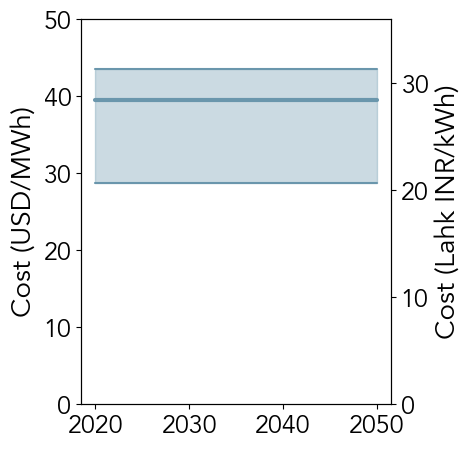

In [905]:
def _plot_phs_energy_cost(ax, df_, 
                          ylabel  = r'Technology Cost (USD/MWh)', 
                          yplabel = r'Technology Cost (Lahk INR/kWh)',
                          xlabel  = True):
    
    idx_low_  = df_['scenario'] == 'STlow'
    idx_mid_  = df_['scenario'] == 'STmid'
    idx_high_ = df_['scenario'] == 'SThigh'

    ax.plot(df_.loc[idx_low_, 'vintage'], df_.loc[idx_low_, 'capital_real_cost_per_kwh'], 
            color = '#6a96ac', lw = 1.5, solid_capstyle='round')
    ax.plot(df_.loc[idx_mid_, 'vintage'], df_.loc[idx_mid_, 'capital_real_cost_per_kwh'],
            color = '#6a96ac', lw = 3, solid_capstyle='round')
    ax.plot(df_.loc[idx_high_, 'vintage'], df_.loc[idx_high_, 'capital_real_cost_per_kwh'],
            color = '#6a96ac', lw = 1.5, solid_capstyle='round')
    
    ax.fill_between(df_.loc[idx_mid_, 'vintage'], 
                    df_.loc[idx_low_, 'capital_real_cost_per_kwh'],
                    df_.loc[idx_high_, 'capital_real_cost_per_kwh'], 
                    color = '#6a96ac', alpha = 0.35, label = 'Pumped Hydro')
    
    # ax.legend(loc     = 'upper right',
    #           frameon = False,
    #           prop    = {'size': 14})
    
    axp = ax.twinx()
    
    ax.xaxis.set_tick_params(labelsize = 18)
    ax.yaxis.set_tick_params(labelsize = 18)
    axp.yaxis.set_tick_params(labelsize = 18)
    
    ax.set_ylabel(ylabel, fontsize = 20)
    axp.set_ylabel(yplabel, fontsize = 20)

    ax.set_ylim(0, 50)
    axp.set_ylim(0, 50*USD_to_INR/1e2)

    axp.yaxis.set_major_formatter(mpl.ticker.StrMethodFormatter('{x:,.0f}'))

    plt.setp(ax.get_xticklabels(), visible = xlabel)

fig, ax = plt.subplots(1, 1, figsize = (4, 5))

_plot_phs_energy_cost(ax, new_hydro_costs_all)

# plt.savefig(path_to_images + '/existing_capacity.png', 
#             bbox_inches = 'tight', 
#             dpi         = 300)

plt.show()

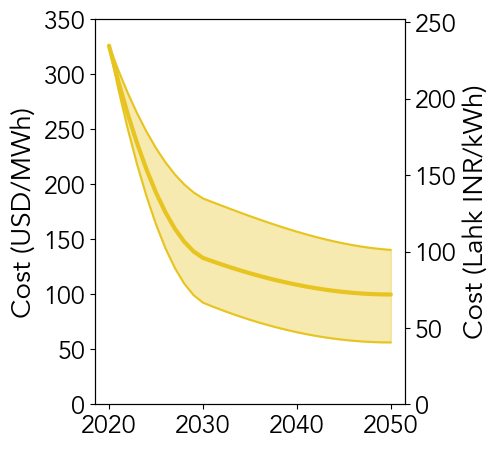

In [906]:
def _plot_battery_energy_cost(ax, df_, 
                              ylabel  = r'Technology Cost (USD/MWh)', 
                              yplabel = r'Technology Cost (Lahk INR/kWh)',
                              xlabel  = True):
    
    idx_low_  = df_['scenario'] == 'STlow'
    idx_mid_  = df_['scenario'] == 'STmid'
    idx_high_ = df_['scenario'] == 'SThigh'

    ax.plot(df_.loc[idx_low_, 'vintage'], df_.loc[idx_low_, 'capital_real_cost_per_kwh'], 
            color = '#e7c41f', lw = 1.5, solid_capstyle='round')
    ax.plot(df_.loc[idx_mid_, 'vintage'], df_.loc[idx_mid_, 'capital_real_cost_per_kwh'],
            color = '#e7c41f', lw = 3, solid_capstyle='round')
    ax.plot(df_.loc[idx_high_, 'vintage'], df_.loc[idx_high_, 'capital_real_cost_per_kwh'],
            color = '#e7c41f', lw = 1.5, solid_capstyle='round')
    
    ax.fill_between(df_.loc[idx_mid_, 'vintage'], 
                    df_.loc[idx_low_, 'capital_real_cost_per_kwh'],
                    df_.loc[idx_high_, 'capital_real_cost_per_kwh'],  
                    color = '#e7c41f', alpha = 0.35, label = 'Battery')
    
#     ax.legend(loc     = 'upper right',
#               frameon = False,
#               prop    = {'size': 14})
    
    ax.xaxis.set_tick_params(labelsize = 18)
    ax.yaxis.set_tick_params(labelsize = 18)
    ax.set_ylabel(ylabel, fontsize = 20)
    
    ax.set_ylim(0, 350)
    
    axp = ax.twinx()
    axp.set_ylim(0, 350*USD_to_INR/1e2)
    axp.yaxis.set_major_formatter(mpl.ticker.StrMethodFormatter('{x:,.0f}'))
    axp.yaxis.set_tick_params(labelsize = 18)
    axp.set_ylabel(yplabel, fontsize = 20)

    plt.setp(ax.get_xticklabels(), visible = xlabel)

fig, ax = plt.subplots(1, 1, figsize = (4, 5))

_plot_battery_energy_cost(ax, new_battery_costs_all)

# plt.savefig(path_to_images + '/existing_capacity.png', 
#             bbox_inches = 'tight', 
#             dpi         = 300)

plt.show()

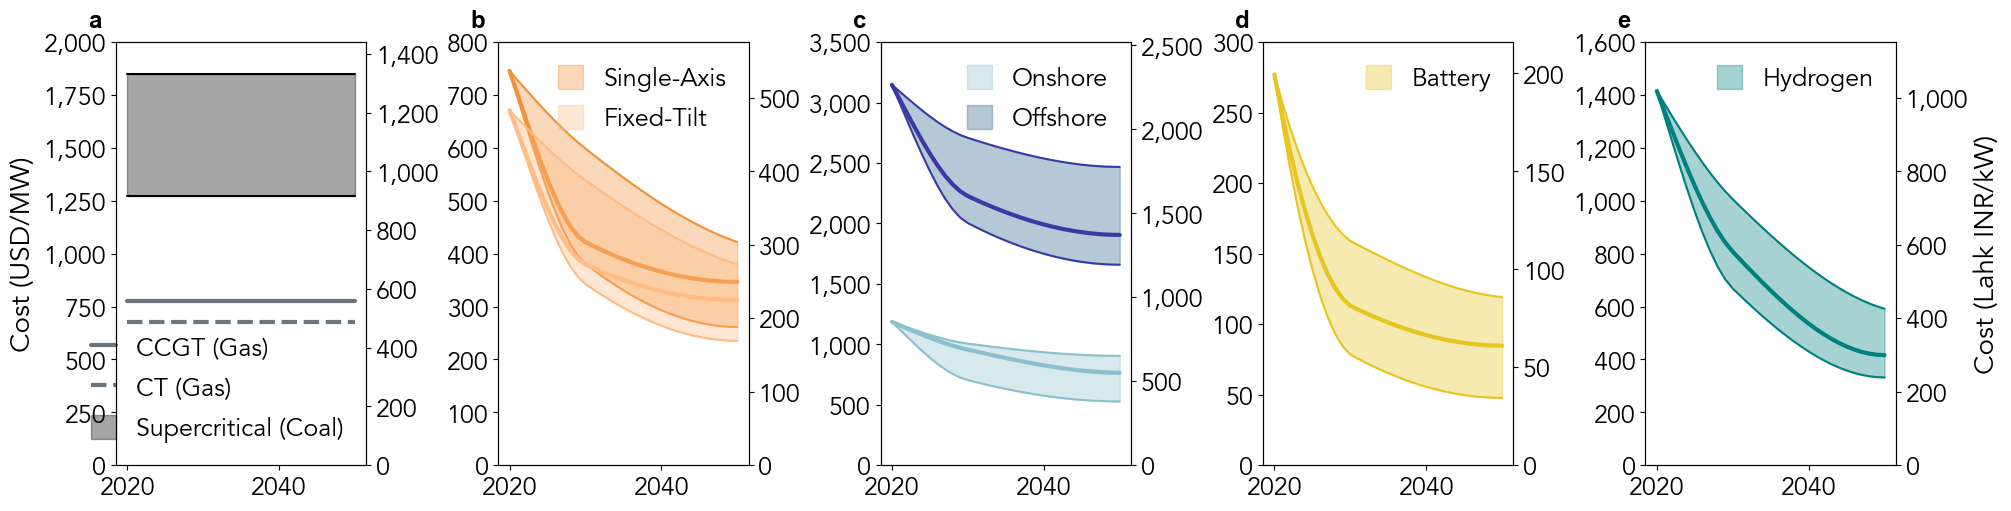

In [907]:
fig, _ax = plt.subplot_mosaic([['a', 'b', 'c', 'd', 'e']],
                              layout      = 'constrained', 
                              figsize     = (20, 5), 
                              gridspec_kw = {'width_ratios': [1, 1, 1, 1, 1]})

for label, ax in _ax.items():
    ax.text(0.0, 1.0, label, 
            transform = ax.transAxes + ScaledTranslation(-20/72, +7/72, fig.dpi_scale_trans),
            fontsize  = 'xx-large', 
            weight    = "bold",
            va        = 'bottom',
            family    = 'Arial')
    
_plot_convectional_cost(_ax['a'], new_conventional_costs_all, yplabel = '')

_plot_solar_cost(_ax['b'], new_solar_costs_all, ylabel = '', yplabel = '')

_plot_wind_cost(_ax['c'], new_wind_costs_all, ylabel = '', yplabel = '')

_plot_battery_power_cost(_ax['d'], new_battery_costs_all, ylabel = '', yplabel = '')
_plot_hydrogen_power_cost(_ax['e'], new_hydrogen_cavern_costs_all, ylabel = '')

# plt.savefig(path_to_images + f'/demand_profiles-{method}.pdf', 
#             bbox_inches = 'tight', 
#             dpi         = 600)

plt.savefig(path_to_images + f'/technology_costs.png', 
            bbox_inches = 'tight', 
            dpi         = 300)

plt.show()

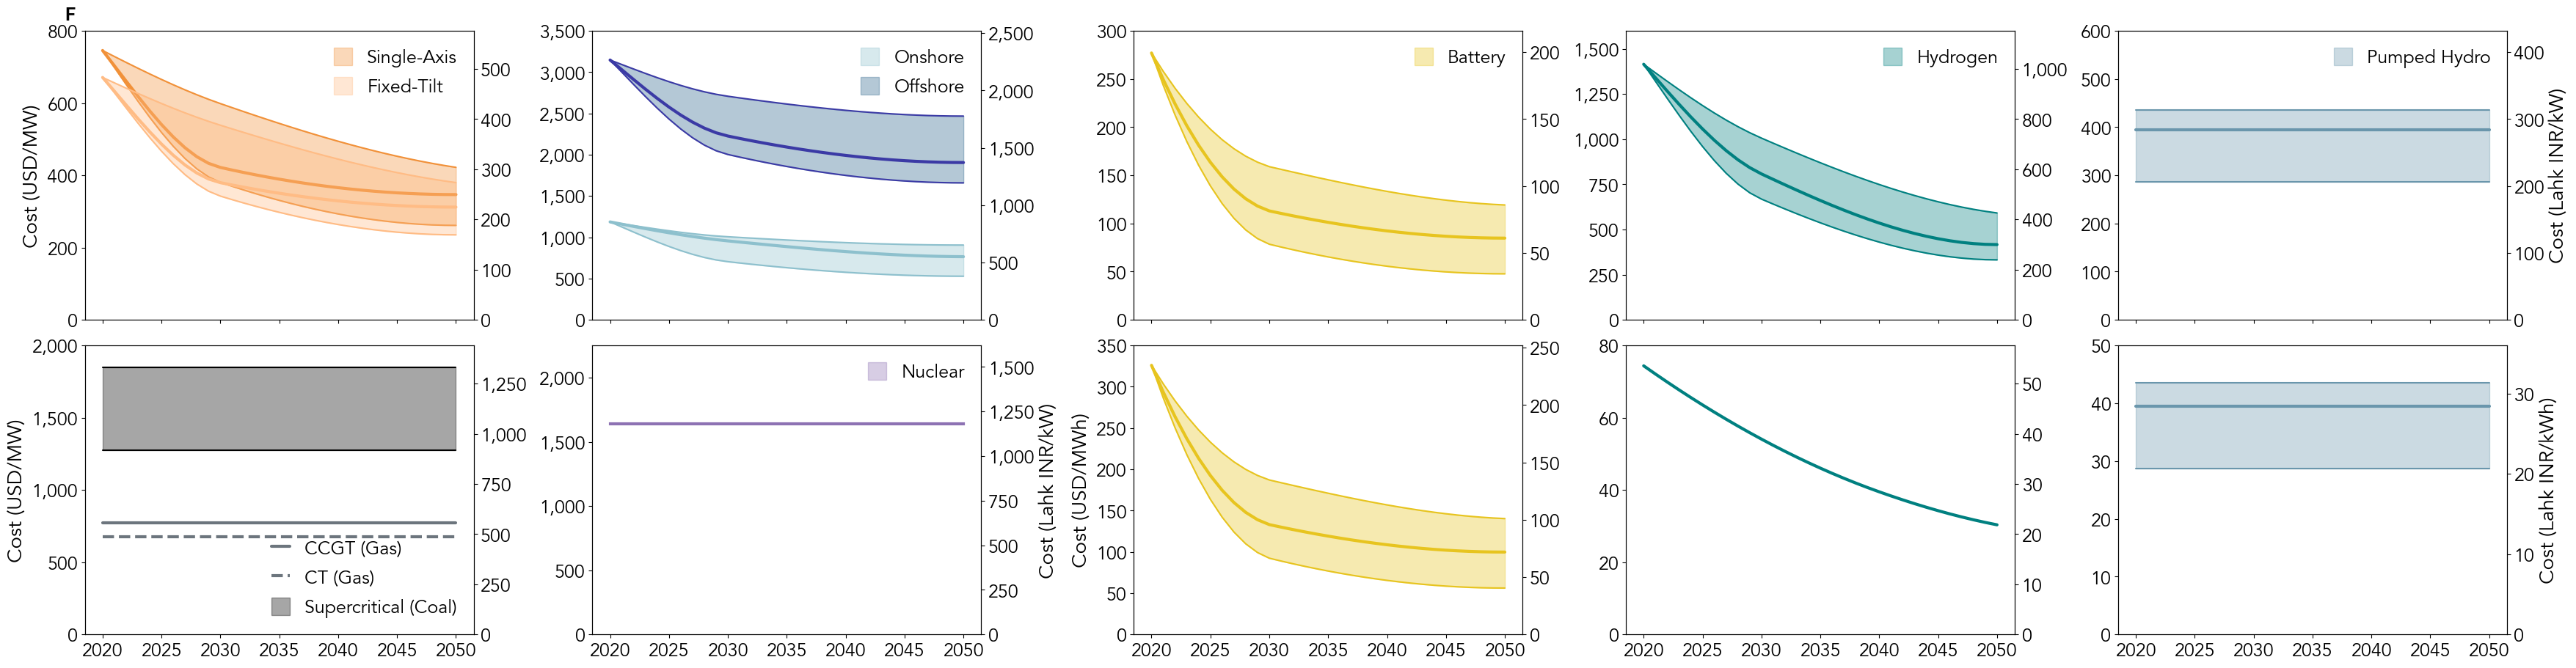

In [1038]:
fig, _ax = plt.subplot_mosaic([['A', 'B', 'C', 'D', 'E'],
                               ['F', 'G', 'H', 'I', 'J']],
                              layout      = 'constrained', 
                              sharex      = True,
                              figsize     = (35, 9), 
                              gridspec_kw = {'wspace': 0.025,
                                             'width_ratios': [1, 1, 1, 1, 1]})


_ax['A'].text(0.0, 1.0, 'F', 
        transform = _ax['A'].transAxes + ScaledTranslation(-20/72, +7/72, fig.dpi_scale_trans),
        fontsize  = 'xx-large', 
        weight    = "bold",
        va        = 'bottom',
        family    = 'Arial')
    

_plot_solar_cost(_ax['A'], new_solar_costs_all, yplabel = '')

_plot_wind_cost(_ax['B'], new_wind_costs_all, ylabel = '', yplabel = '')

_plot_battery_power_cost(_ax['C'], new_battery_costs_all, ylabel = '', yplabel = '')
_plot_hydrogen_power_cost(_ax['D'], new_hydrogen_cavern_costs_all, ylabel = '', yplabel = '')

_plot_phs_power_cost(_ax['E'], new_hydro_costs_all, ylabel = '')

_plot_convectional_cost(_ax['F'], new_conventional_costs_all, yplabel = '')

_plot_nuclear_cost(_ax['G'], new_nuclear_costs_all, ylabel = '')

_plot_battery_energy_cost(_ax['H'], new_battery_costs_all, yplabel = '')

_plot_hydrogen_energy_cost(_ax['I'], new_hydrogen_tank_costs_all, ylabel = '', yplabel = '')

_plot_phs_energy_cost(_ax['J'], new_hydro_costs_all, ylabel = '')

plt.savefig(path_to_images + f'/overview-technology_costs.pdf', 
            bbox_inches = 'tight', 
            dpi         = 600)

plt.savefig(path_to_images + f'/overview-technology_costs.png', 
            bbox_inches = 'tight', 
            dpi         = 300)

plt.show()

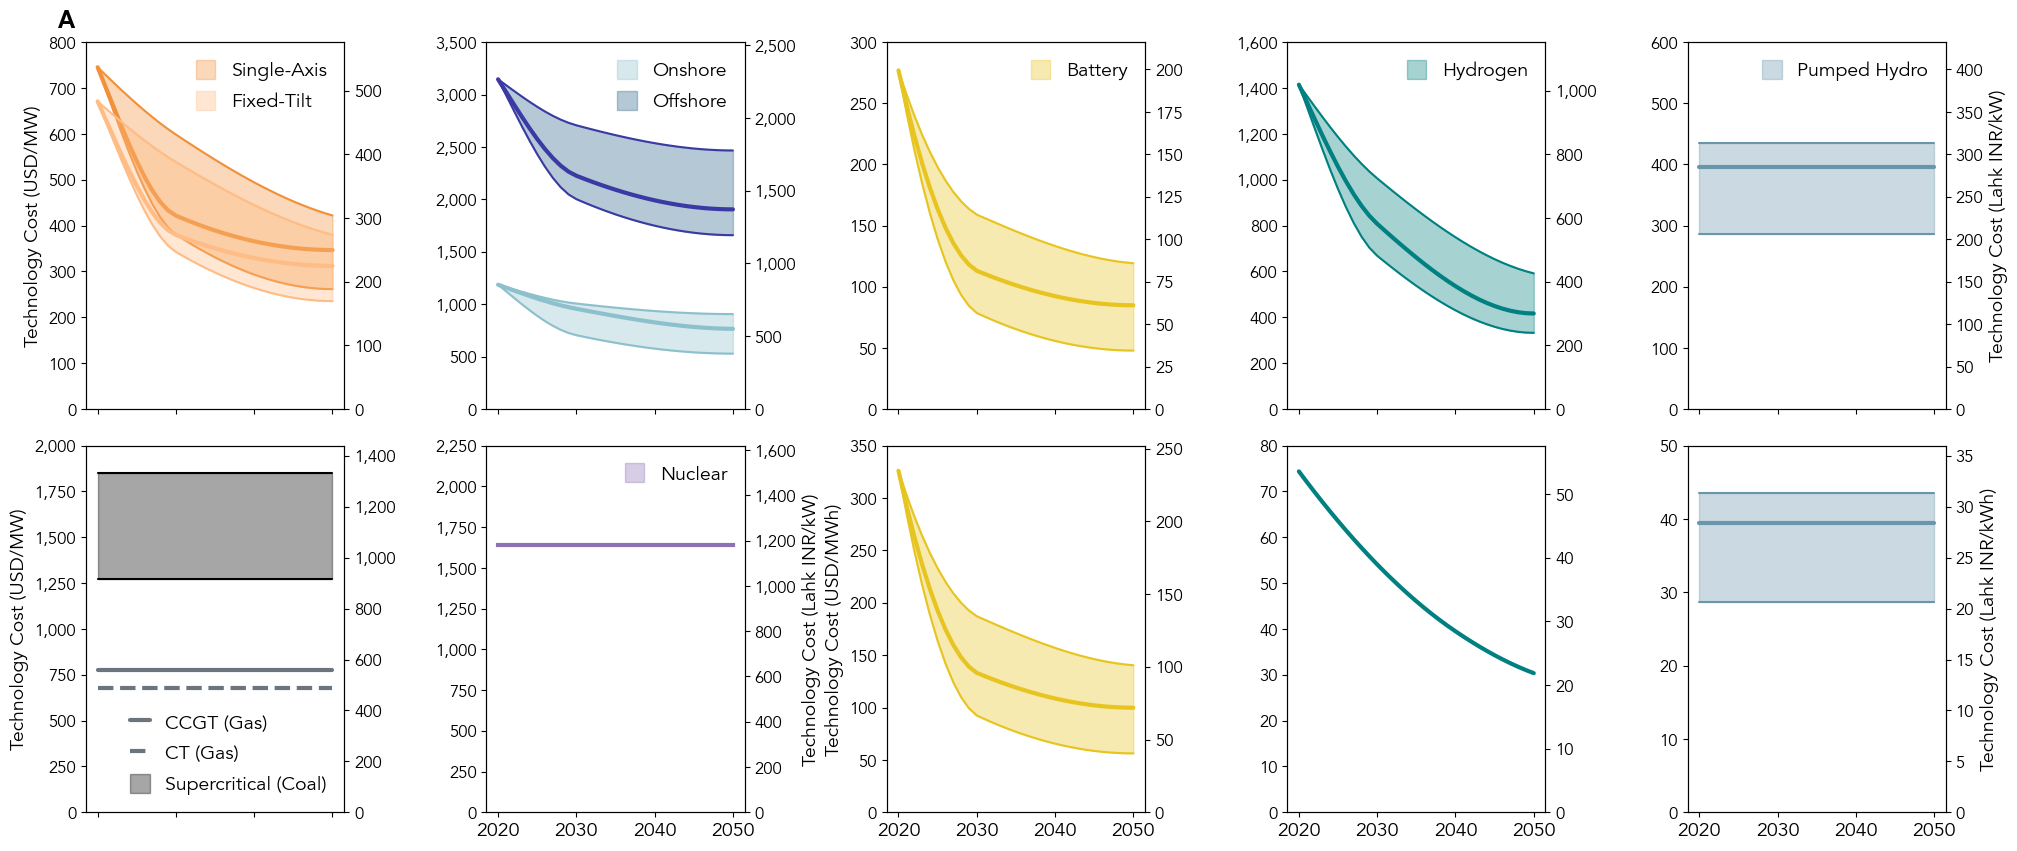

In [719]:
# fig, _ax = plt.subplot_mosaic([['A']],
#                               figsize     = (24, 10), 
#                               gridspec_kw = {'width_ratios': [1]})


# for label, ax in _ax.items():
#     ax.text(0.0, 1.0, label, 
#             transform = ax.transAxes + ScaledTranslation(-20/72, +7/72, fig.dpi_scale_trans),
#             fontsize  = 'xx-large', 
#             weight    = "bold",
#             va        = 'bottom',
#             family    = 'Arial')

# _axp = gridspec.GridSpecFromSubplotSpec(2, 5, subplot_spec = _ax['A'],
#                                               wspace       = .55, 
#                                               hspace       = 0.1)

# ax = fig.add_subplot(_axp[0, 0])
# _plot_solar_cost(ax, new_solar_costs_all, yplabel = '', xlabel = False)
# fig.add_subplot(ax)

# ax = fig.add_subplot(_axp[0, 1])
# _plot_wind_cost(ax, new_wind_costs_all, ylabel = '', yplabel = '', xlabel = False)
# fig.add_subplot(ax)

# ax = fig.add_subplot(_axp[0, 2])
# _plot_battery_power_cost(ax, new_battery_costs_all, ylabel = '', yplabel = '', xlabel = False)
# fig.add_subplot(ax)

# ax = fig.add_subplot(_axp[0, 3])
# _plot_hydrogen_power_cost(ax, new_hydrogen_cavern_costs_all, ylabel = '', yplabel = '', xlabel = False)
# fig.add_subplot(ax)

# ax = fig.add_subplot(_axp[0, 4])
# _plot_phs_power_cost(ax, new_hydro_costs_all, ylabel = '', xlabel = False)
# fig.add_subplot(ax)

# ax = fig.add_subplot(_axp[1, 0])
# _plot_convectional_cost(ax, new_conventional_costs_all, yplabel = '', xlabel = False)
# fig.add_subplot(ax)

# ax = fig.add_subplot(_axp[1, 1])
# _plot_nuclear_cost(ax, new_nuclear_costs_all, ylabel = '')
# fig.add_subplot(ax)

# ax = fig.add_subplot(_axp[1, 2])
# _plot_battery_energy_cost(ax, new_battery_costs_all, yplabel = '')
# fig.add_subplot(ax)

# ax = fig.add_subplot(_axp[1, 3])
# _plot_hydrogen_energy_cost(ax, new_hydrogen_tank_costs_all, ylabel = '', yplabel = '')
# fig.add_subplot(ax)

# ax = fig.add_subplot(_axp[1, 4])
# _plot_phs_energy_cost(ax, new_hydro_costs_all, ylabel = '')
# fig.add_subplot(ax)

# # plt.savefig(path_to_images + f'/demand_profiles-{method}.pdf', 
# #             bbox_inches = 'tight', 
# #             dpi         = 600)

# # plt.savefig(path_to_images + f'/technology_costs.png', 
# #             bbox_inches = 'tight', 
# #             dpi         = 300)

# _ax['A'].axis('off')

# plt.show()

# Capacity and Transmission

In [80]:
tech_labels_ = pd.read_csv(path_to_csvs + '/technology_labels.csv')
print(tech_labels_)

                  group              technology group_color    color  order
0                  Coal  Subcritical_Coal_Large     #343a40  #343a40      1
1                  Coal  Subcritical_Coal_Small     #343a40  #343a40      1
2                  Coal      Supercritical_Coal     #343a40  #343a40      1
3                   Gas                    CCGT     #6c757d  #6c757d      2
4                   Gas                      CT     #6c757d  #6c757d      2
5                Diesel                  Diesel     #924B00  #924B00      3
6                 Hydro               Hydro_ROR     #2a648a  #2a648a      6
7                 Hydro           Hydro_Storage     #2a648a  #2a648a      6
8                 Other                 Biomass     #6ba661  #6a96ac      5
9                 Other                     WHR     #6ba661  #6ba661      5
10             Hydrogen                Hydrogen        teal     teal     11
11              Battery                 Battery     #e7c41f  #e7c41f     10
12          

In [337]:
def _group_capacity_technologies(capacity_, tech_labels_):

    for group in tech_labels_['group'].unique():
        capacity_.loc[capacity_['technology'].isin(tech_labels_.loc[tech_labels_['group'] == group, 'technology']), 'technology'] = group
       
    capacity_.loc[capacity_['technology'] == 'Pumped Storage', 'technology'] = 'Hydro'
    capacity_ = capacity_.groupby(['technology', 
                                   'load_zone']).agg({'capacity_mw': 'sum'})

    return capacity_.reset_index(drop = False)

path_to_scenarios = '/Users/Guille/Desktop/india_power/scenarios/demand/VREmid_STmid_CONVmid_H2_RES_10PRM_CC_50RPS_90CAP_500GW_ICEDmid/inputs/'

tx_                   = pd.read_csv(path_to_scenarios + 'specified_transmission_line_capacities.tab', sep = '\t')
tx_['load_zone_from'] = tx_['transmission_line'].apply(lambda x: x.split('-')[0])
tx_['load_zone_to']   = tx_['transmission_line'].apply(lambda x: x.split('-')[1])
tx_                   = tx_.loc[tx_['period'] == 2020].reset_index(drop = True)
tx_                   = tx_[['specified_tx_max_mw', 'load_zone_from', 'load_zone_to']]
tx_                   = tx_.rename(columns = {'specified_tx_max_mw': 'tx_mw'})

cap_ = pd.read_csv(path_to_scenarios + 'spec_capacity_period_params.tab', sep = '\t')
cap_ = cap_.loc[cap_['period'] == 2020].reset_index(drop = True)
cap_ = cap_[['project', 'specified_capacity_mw']].set_index('project')

proj_ = pd.read_csv(path_to_scenarios + 'projects.tab', sep = '\t')
proj_ = proj_[['project', 'technology', 'load_zone']].set_index('project')

cap_['technology'] = proj_.loc[cap_.index, ['technology']]
cap_['load_zone']  = proj_.loc[cap_.index, ['load_zone']]
cap_               = cap_.reset_index(drop = True)
cap_               = cap_.rename(columns = {'specified_capacity_mw': 'capacity_mw'})
cap_               = cap_.groupby(['capacity_mw', 'technology', 'load_zone']).agg('sum').reset_index(drop = False)
#print(cap_)

group_cap_ = _group_capacity_technologies(cap_, tech_labels_)
total_cap_ = group_cap_[['load_zone', 'capacity_mw']].groupby(['load_zone']).agg('sum').reset_index(drop = False)
print(group_cap_['technology'].unique())



['Coal' 'Diesel' 'Gas' 'Hydro' 'Nuclear' 'Other' 'Solar' 'Wind']


In [357]:
def _opt_dist(x_, y_, d = 1.35, delta = 0.1):
    
    def __update_position(x, x_0, z):
        return x + ((x - x_0)/z)*delta, x_0 + ((x_0 - x)/z)*delta  
    
    while True:
        flag = True
        for i in range(x_.shape[0]):
            for j in range(x_.shape[0]):
                if i != j:
                    z = np.sqrt( (x_[j] - x_[i])**2 + (y_[j] - y_[i])**2 )
                    if z < d:
                        x_[j], x_[i] = __update_position(x_[j], x_[i], z)
                        y_[j], y_[i] = __update_position(y_[j], y_[i], z)
                        flag = False
        if flag:
            break

    return x_, y_


_map = gpd.read_file(path_to_data + r"map/india-polygon.shp").to_crs("epsg:4326")
#_map = _map.drop([0, 15])

_nothern      = _map.loc[[4, 10, 11, 22, 24, 25, 30, 31, 35, 36]].dissolve().buffer(.025)#.to_crs(epsg=3395).to_crs("epsg:4326")
_northeastern = _map.loc[[1, 2, 18, 19, 20, 21, 29]].dissolve()
_western      = _map.loc[[5, 6, 7, 8, 9, 16, 17]].dissolve()
_southern     = _map.loc[[13, 14, 23, 27, 28, 34]].dissolve()
_eastern      = _map.loc[[3, 12, 26, 32, 33]].dissolve()
_regions      = pd.concat([_northeastern, _western, _southern, _eastern], axis = 0)

city_ = pd.read_csv(path_to_input + r"transmission/major_cities_india.csv")
city_ = city_.drop(columns = ['state', 'major_city'])
city_ = city_.rename(columns = {'acronym': 'load_zone_abr'})
city_ = city_.drop([28, 34, 35]).reset_index(drop = True)

load_zones_ = pd.read_csv(path_to_input + r"/india_zones.csv")
load_zones_ = load_zones_.drop(columns = ['state', 'rps_zone'])

load_zones_ = load_zones_.drop([3, 35, 36]).reset_index(drop = True)
load_zones_ = pd.merge(city_, load_zones_, on  = 'load_zone_abr', 
                                           how = 'inner')

load_zones_p_ = load_zones_.copy()

load_zones_p_['longitude'], load_zones_p_['latitude'] = _opt_dist(load_zones_p_['longitude'].to_numpy(), 
                                                                  load_zones_p_['latitude'].to_numpy())

total_cap_['capacity_gw'] = (total_cap_['capacity_mw']/1000.).round(2)
total_cap_['position'] = 1

total_cap_.loc[15, 'position'] = 0
total_cap_.loc[7, 'position']  = 0
total_cap_.loc[25, 'position'] = 0
total_cap_.loc[4, 'position']  = 2
total_cap_.loc[14, 'position'] = 0
total_cap_.loc[27, 'position'] = 0
total_cap_.loc[20, 'position'] = 0
total_cap_.loc[30, 'position'] = 0
total_cap_.loc[2, 'position']  = 0
total_cap_.loc[10, 'position'] = 0
total_cap_.loc[26, 'position'] = 0

load_zones_p_.loc[30, 'longitude'] += .15
load_zones_p_.loc[29, 'longitude'] -= .4

/var/folders/0c/ffx2kgyn7xq4krqrpsv67l3m0000gn/T/ipykernel_46672/1337525157.py:25: UserWarning: Geometry is in a geographic CRS. Results from 'buffer' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  _nothern      = _map.loc[[4, 10, 11, 22, 24, 25, 30, 31, 35, 36]].dissolve().buffer(.025)#.to_crs(epsg=3395).to_crs("epsg:4326")


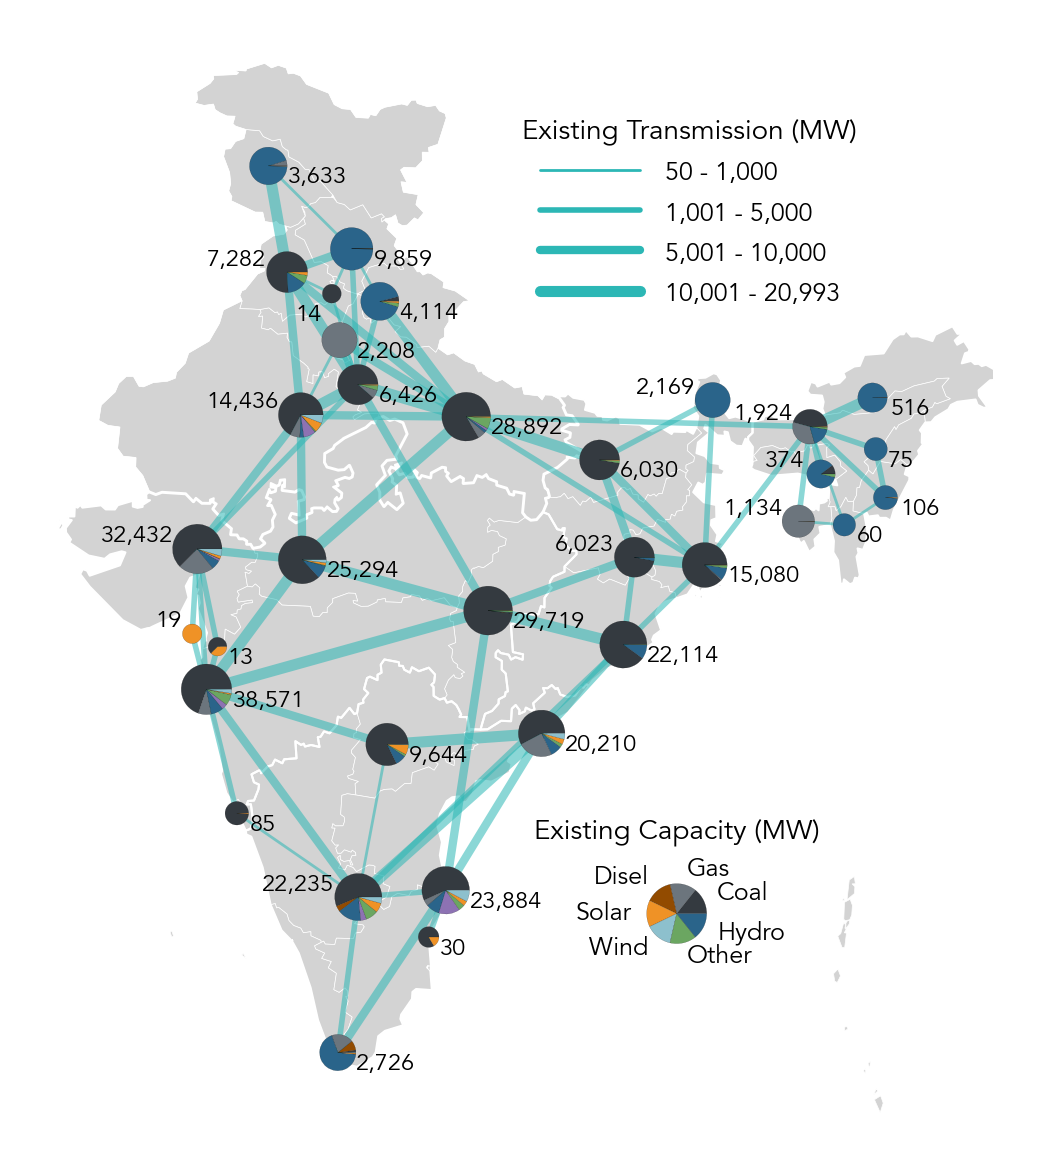

In [1010]:
def _plot_specified_capacity(ax, tx_, group_cap_, total_cap_, load_zones_):

               
    for i in range(tx_.shape[0]):

        load_zone_to_   = load_zones_.loc[load_zones_['load_zone'] == tx_.loc[i, 'load_zone_to']]
        load_zone_from_ = load_zones_.loc[load_zones_['load_zone'] == tx_.loc[i, 'load_zone_from']]

        x_ = np.concatenate([load_zone_from_['latitude'].to_numpy(), load_zone_to_['latitude'].to_numpy()], axis = 0)
        y_ = np.concatenate([load_zone_from_['longitude'].to_numpy(), load_zone_to_['longitude'].to_numpy()], axis = 0)

        #z = np.sqrt(np.absolute(tx_.loc[i, 'tx_mw'])/1e3)

        if tx_.loc[i, 'tx_mw'] < 1000.:
            ax.plot(y_, x_, lw             = 2., 
                            zorder         = 10, 
                            color          = '#2cb7b5', 
                            solid_capstyle ='round', 
                            alpha          = .55)

        if (tx_.loc[i, 'tx_mw'] < 5000.) & (tx_.loc[i, 'tx_mw'] >= 1000.):
            ax.plot(y_, x_, lw             = 4, 
                            zorder         = 10, 
                            color          = '#2cb7b5', 
                            solid_capstyle ='round', 
                            alpha          = .55)

        if (tx_.loc[i, 'tx_mw'] < 10000.) & (tx_.loc[i, 'tx_mw'] >= 5000.):
            ax.plot(y_, x_, lw             = 6, 
                            zorder         = 10, 
                            color          = '#2cb7b5', 
                            solid_capstyle ='round', 
                            alpha          = .55)

        if tx_.loc[i, 'tx_mw'] >= 10000.:
            ax.plot(y_, x_, lw             = 8, 
                            zorder         = 10, 
                            color          = '#2cb7b5', 
                            solid_capstyle ='round', 
                            alpha          = .55)

    ax.set_xticks([], [])
    ax.set_yticks([], [])
    ax.spines[['right', 'top', 'left', 'bottom']].set_visible(False)

    for i in range(total_cap_.shape[0]):

        load_zone_ = load_zones_.loc[load_zones_['load_zone'] == total_cap_.loc[i, 'load_zone']]
        cap_ = group_cap_.loc[group_cap_['load_zone'] == total_cap_.loc[i, 'load_zone'], ['technology', 'capacity_mw']]

        total = total_cap_.loc[i, 'capacity_mw']
        #totalp = total_cap_.loc[i, 'capacity_gw']
        totalp = int(total)

        width = np.sqrt(np.sqrt(np.sqrt(total/1e3)))/2.5

        axp_ = inset_axes(ax, width          = width, 
                              height         = width, 
                              bbox_to_anchor = (load_zone_['longitude'], load_zone_['latitude']),
                              loc            = 10, 
                              bbox_transform = ax.transData, 
                              borderpad      = 0)
        
        x = 0
        if len(str(totalp)) < 3:
            x = -6
        if len(str(totalp)) > 3:
            x = 4
        if len(str(totalp)) > 4:
            x = 8
            
        if total_cap_.loc[i, 'position'] == 0:
            axp_.set_ylabel(f'{totalp:,}', fontsize = 17, labelpad = 14 + x, rotation = 0)
        if total_cap_.loc[i, 'position'] == 1:
            axp_.set_ylabel(f'{totalp:,}', fontsize = 17, labelpad = 14 + x, rotation = 0)
            axp_.yaxis.set_label_position('right') 
        if total_cap_.loc[i, 'position'] == 2:
            axp_.set_xlabel(f'{totalp:,}', fontsize = 17, labelpad = -1.5, x = -.5)
        if total_cap_.loc[i, 'position'] == 3:
            axp_.set_xlabel(f'{totalp:,}', fontsize = 17, labelpad = -1.5)
            axp_.xaxis.set_label_position('top') 

        axp_.pie(cap_['capacity_mw']/total,
                 wedgeprops = {'edgecolor': 'black', 'linewidth': .1}, 
                 colors     = [tech_labels_.loc[tech_labels_['group'] == tech, 'group_color'].to_numpy()[0] for tech in cap_['technology']])

    _nothern.plot(ax = ax, zorder = 9, color = 'None', lw = 1.5, edgecolor = 'white')
    _northeastern.plot(ax = ax, zorder = 9, color = 'None', lw = 1.5, edgecolor = 'white')
    _western.plot(ax = ax, zorder = 9, color = 'None', lw = 1.5, edgecolor = 'white')
    _southern.plot(ax = ax, zorder = 9, color = 'None', lw = 1.5, edgecolor = 'white')
    _eastern.plot(ax = ax, zorder = 9, color = 'None', lw = 1.5, edgecolor = 'white')
    _map.plot(ax = ax, zorder = 8, color = 'lightgray', lw = 0.5, edgecolor = 'white')

    axp_ = inset_axes(ax, width          = .75, 
                          height         = .75, 
                          bbox_to_anchor = (87.5, 12.5),
                          loc            = 10, 
                          bbox_transform = ax.transData, 
                          borderpad      = 0)

    axp_.set_title('Existing Capacity (MW)', size = 20, y = 1.375)
    axp_.pie([1, 1, 1, 1, 1, 1, 1], 
             wedgeprops    = {'edgecolor': 'black', 'linewidth': .1},
             colors        = ['#343a40', '#6c757d', '#924B00', '#ef9226', '#8dc0cd', '#6ba661', '#2a648a'],
             labels        = ['Coal', 'Gas', 'Disel', 'Solar', 'Wind', 'Other', 'Hydro'], 
             labeldistance = 1.5, 
             textprops     = {'fontsize': 18})
    # #95cca3 #2cb7b5
    line1 = Line2D([], [], color = '#2cb7b5', lw = 2, solid_capstyle ='round')
    line2 = Line2D([], [], color = '#2cb7b5', lw = 4, solid_capstyle ='round')
    line3 = Line2D([], [], color = '#2cb7b5', lw = 6, solid_capstyle ='round')
    line4 = Line2D([], [], color = '#2cb7b5', lw = 8, solid_capstyle ='round')

    ax.legend((line1, line2, line3, line4), ('50 - 1,000', '1,001 - 5,000', '5,001 - 10,000', '10,001 - 20,993'), 
               title_fontsize = 20,
               title          = 'Existing Transmission (MW)',
               handlelength   = 4.,
               handletextpad  = 1.,
               labelspacing   = .5,
               frameon        = False, 
               bbox_to_anchor = (0.475, 0.925), 
               prop           = {'size': 18})

    # ax2 = ax.twinx()
    # ax2.bar(0., 0., 0., color  = '#343a40',
    #                    label  = 'Coal')

    # ax2.bar(0., 0., 0., color  = '#6c757d',
    #                    label  = 'Gas')

    # ax2.bar(0., 0., 0., color  = '#924B00',
    #                    label  = 'Diesel')

    # ax2.bar(0., 0., 0., color  = '#ef9226',
    #                    label  = 'Solar')

    # ax2.bar(0., 0., 0., color  = '#8dc0cd',
    #                    label  = 'Wind')

    # ax2.bar(0., 0., 0., color  = '#6ba661',
    #                    label  = 'Other')

    # ax2.bar(0., 0., 0., color  = '#2a648a',
    #                    label  = 'Hydro')

    # ax2.legend(loc            = 'center left',
    #            title          = 'Resource',
    #            title_fontsize = 16,
    #            bbox_to_anchor = (.8, 0.125),
    #            frameon        = False,
    #            prop           = {'size': 12})
    # ax2.axis('off')

fig, ax = plt.subplots(1, 1, figsize = (17, 15))

_plot_specified_capacity(ax, tx_, group_cap_, total_cap_, load_zones_p_)

plt.savefig(path_to_images + '/existing_capacity.png', 
            bbox_inches = 'tight', 
            dpi         = 300)

plt.show()

# Solar Resource

In [939]:
_map = gpd.read_file(path_to_data + r"map/india-polygon.shp").to_crs("epsg:4326")
#_map = _map.drop([0, 15])

_nothern      = _map.loc[[4, 10, 11, 22, 24, 25, 30, 31, 35, 36]].dissolve().buffer(.025)#.to_crs(epsg=3395).to_crs("epsg:4326")
_northeastern = _map.loc[[1, 2, 18, 19, 20, 21, 29]].dissolve()
_western      = _map.loc[[5, 6, 7, 8, 9, 16, 17]].dissolve()
_southern     = _map.loc[[13, 14, 23, 27, 28, 34]].dissolve()
_eastern      = _map.loc[[3, 12, 26, 32, 33]].dissolve()
_regions      = pd.concat([_northeastern, _western, _southern, _eastern], axis = 0)


/var/folders/0c/ffx2kgyn7xq4krqrpsv67l3m0000gn/T/ipykernel_46672/1591140660.py:4: UserWarning: Geometry is in a geographic CRS. Results from 'buffer' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  _nothern      = _map.loc[[4, 10, 11, 22, 24, 25, 30, 31, 35, 36]].dissolve().buffer(.025)#.to_crs(epsg=3395).to_crs("epsg:4326")


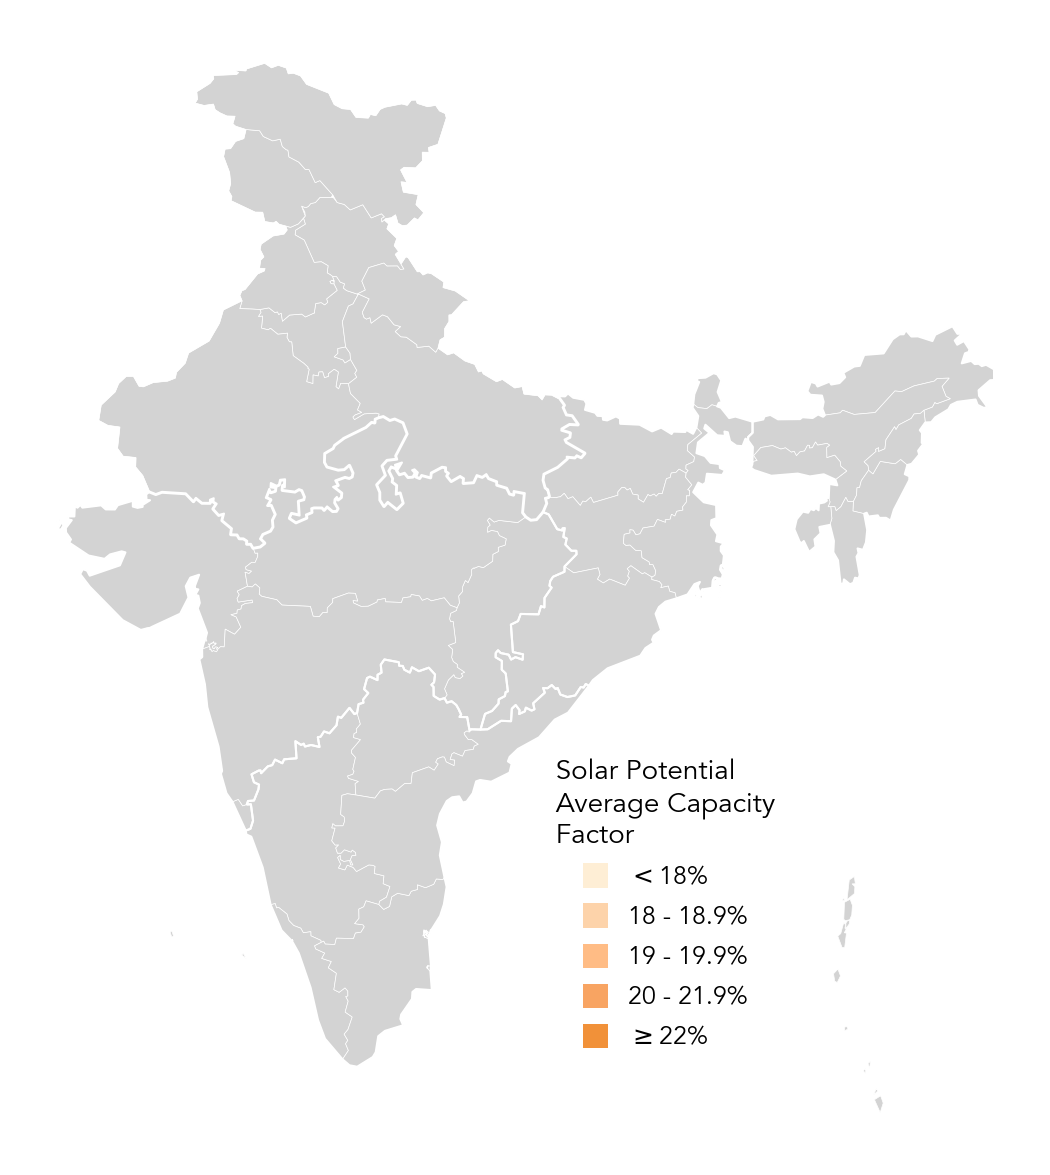

In [1029]:
def _plot_solar_resource(ax):

    _nothern.plot(ax = ax, zorder = 9, color = 'None', lw = 1.5, edgecolor = 'white')
    _northeastern.plot(ax = ax, zorder = 9, color = 'None', lw = 1.5, edgecolor = 'white')
    _western.plot(ax = ax, zorder = 9, color = 'None', lw = 1.5, edgecolor = 'white')
    _southern.plot(ax = ax, zorder = 9, color = 'None', lw = 1.5, edgecolor = 'white')
    _eastern.plot(ax = ax, zorder = 9, color = 'None', lw = 1.5, edgecolor = 'white')
    _map.plot(ax = ax, zorder = 8, color = 'lightgray', lw = 0.5, edgecolor = 'white')

    ax.set_xticks([], [])
    ax.set_yticks([], [])
    ax.spines[['right', 'top', 'left', 'bottom']].set_visible(False)

    ax.bar(0., 0., 0., color  = '#feeed5',
                       label  = r'$<$18%')

    ax.bar(0., 0., 0., color  = '#fdd3aa',
                       label  = '18 - 18.9%')

    ax.bar(0., 0., 0., color  = '#ffbc85',
                       label  = '19 - 19.9%')

    ax.bar(0., 0., 0., color  = '#f8a462',
                       label  = '20 - 21.9%')

    ax.bar(0., 0., 0., color  = '#f19139',
                       label  = r'$\geq$22%')

    ax.legend(loc            = 'center left',
               title          = ' Solar Potential \n Average Capacity \n Factor',
               title_fontsize = 20,
               bbox_to_anchor = (.5, 0.225),
               frameon        = False,
               prop           = {'size': 18})
    
    
    
fig, ax = plt.subplots(1, 1, figsize = (17, 15))

_plot_solar_resource(ax)

plt.show()

# Wind Resource

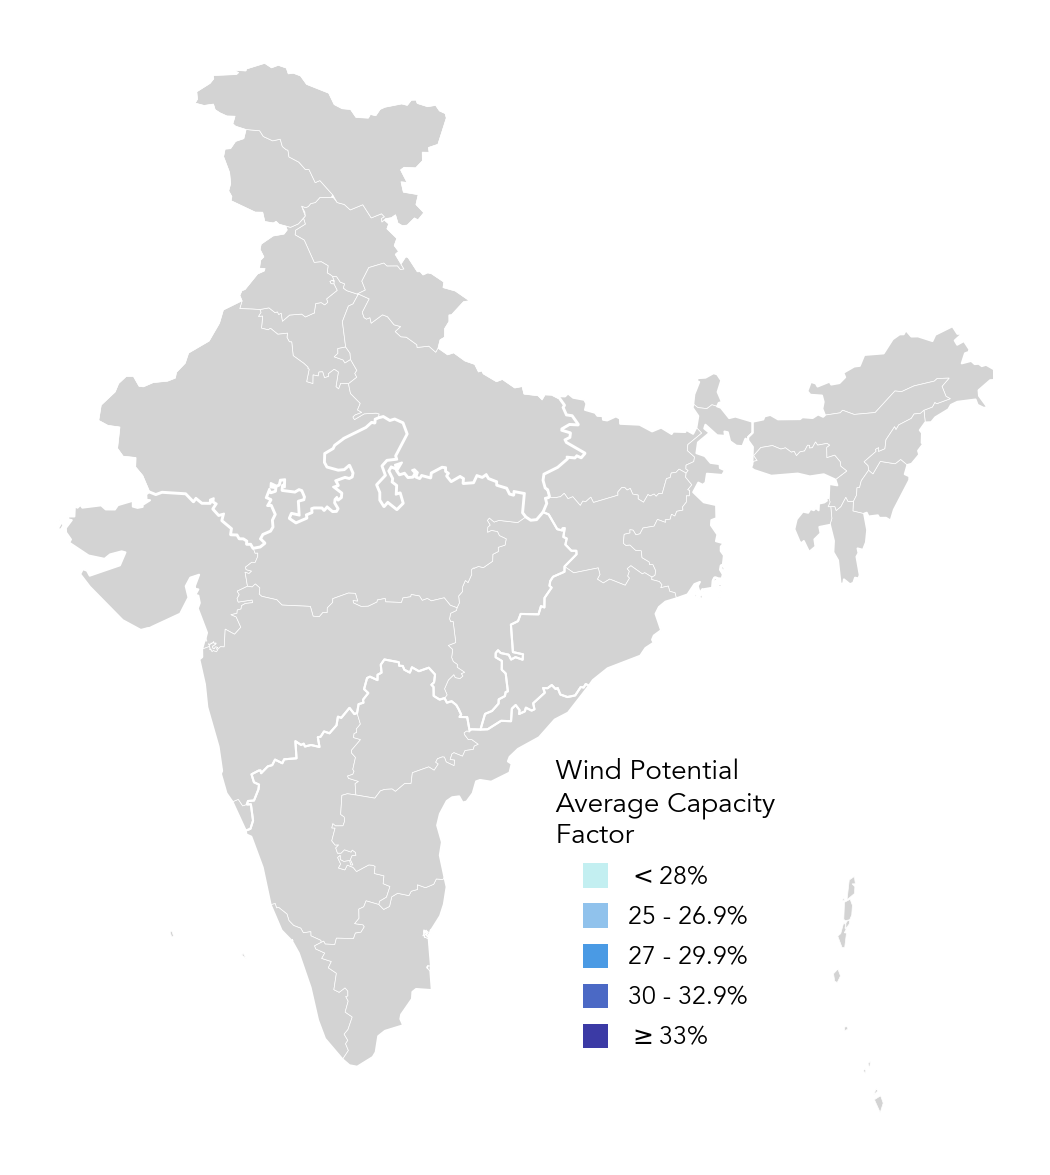

In [1030]:
def _plot_wind_resource(ax):

    _nothern.plot(ax = ax, zorder = 9, color = 'None', lw = 1.5, edgecolor = 'white')
    _northeastern.plot(ax = ax, zorder = 9, color = 'None', lw = 1.5, edgecolor = 'white')
    _western.plot(ax = ax, zorder = 9, color = 'None', lw = 1.5, edgecolor = 'white')
    _southern.plot(ax = ax, zorder = 9, color = 'None', lw = 1.5, edgecolor = 'white')
    _eastern.plot(ax = ax, zorder = 9, color = 'None', lw = 1.5, edgecolor = 'white')
    _map.plot(ax = ax, zorder = 8, color = 'lightgray', lw = 0.5, edgecolor = 'white')

    ax.set_xticks([], [])
    ax.set_yticks([], [])
    ax.spines[['right', 'top', 'left', 'bottom']].set_visible(False)

    ax.bar(0., 0., 0., color  = '#c3eff1',
                       label  = r'$<$28%')

    ax.bar(0., 0., 0., color  = '#90c2ec',
                       label  = '25 - 26.9%')

    ax.bar(0., 0., 0., color  = '#4a9ae4',
                       label  = '27 - 29.9%')

    ax.bar(0., 0., 0., color  = '#4b69c5',
                       label  = '30 - 32.9%')

    ax.bar(0., 0., 0., color  = '#3b3aa5',
                       label  = r'$\geq$33%')

    ax.legend(loc             = 'center left',
               title          = ' Wind Potential \n Average Capacity \n Factor',
               title_fontsize = 20,
               bbox_to_anchor = (.5, 0.225),
               frameon        = False,
               prop           = {'size': 18})
    
    
fig, ax = plt.subplots(1, 1, figsize = (17, 15))

_plot_wind_resource(ax)

plt.show()

# Mosaic

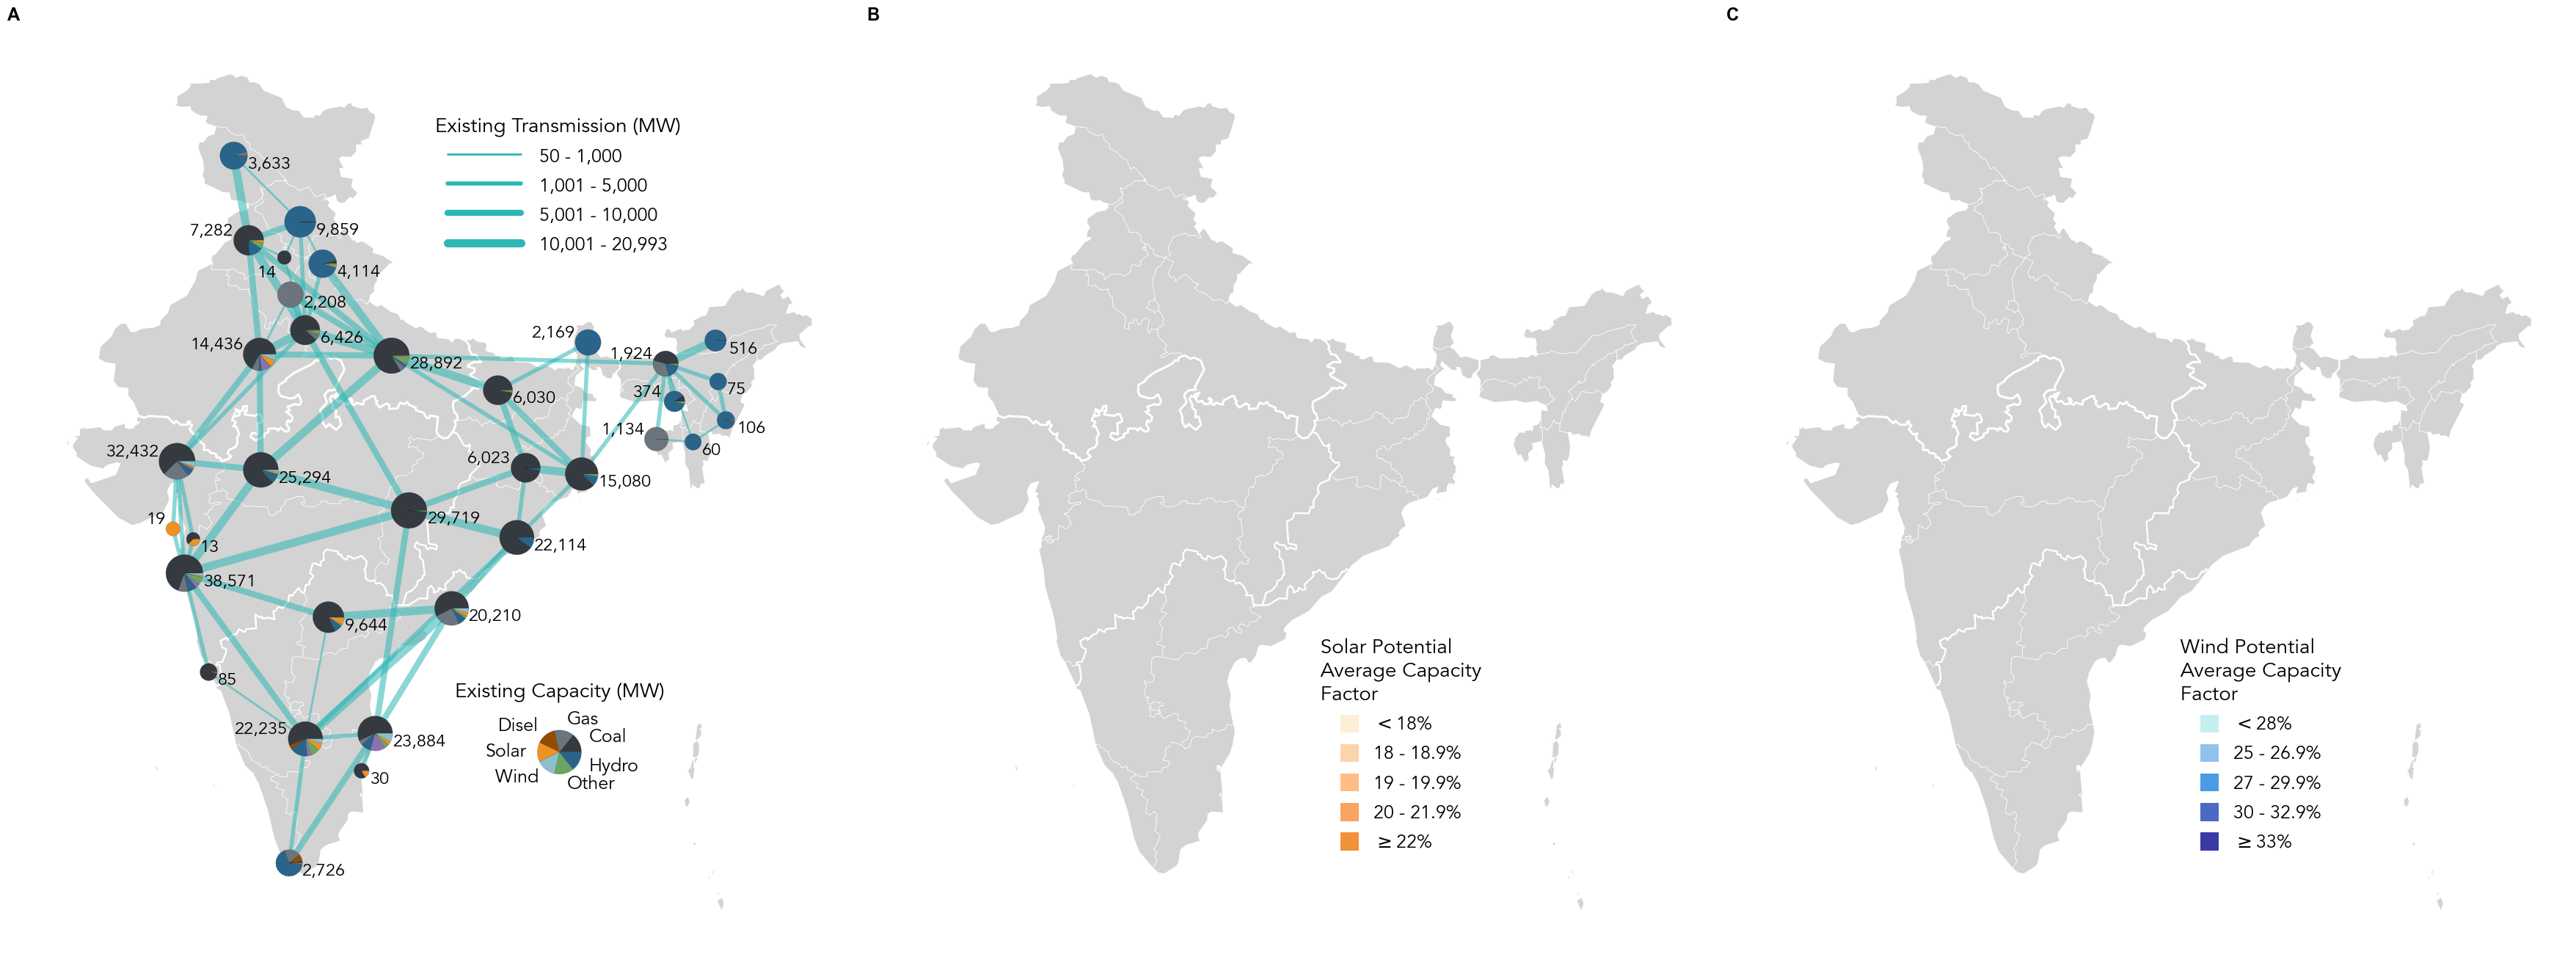

In [1031]:
fig, _ax = plt.subplot_mosaic([['A',  'B', 'C']],
                              layout      = 'constrained', 
                              figsize     = (35, 15), 
                              gridspec_kw = {'width_ratios': [1, 1, 1]})

for label, ax in _ax.items():
    ax.text(0.0, 1.0, label, 
            transform = (ax.transAxes + ScaledTranslation(-20/72, +7/72, fig.dpi_scale_trans)),
            fontsize  = 'xx-large', 
            weight    = "bold",
            va        = 'bottom',
            family    = 'Arial')

_plot_specified_capacity(_ax['A'], tx_, group_cap_, total_cap_, load_zones_p_)

_plot_solar_resource(_ax['B'])

_plot_wind_resource(_ax['C'])

plt.savefig(path_to_images + '/overview-capacity_and_potential.png', 
            bbox_inches = 'tight', 
            dpi         = 300)

plt.savefig(path_to_images + '/overview-capacity_and_potential.pdf', 
            bbox_inches = 'tight', 
            dpi         = 600)

plt.show()